In [1]:
from tsai.all import *
import os
import re
import shutil
import glob
import datetime
import time
import mne

import pandas as pd
import numpy as np
import numpy as np
import sklearn.metrics as skm
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.utils import resample
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from scipy.stats import skew, kurtosis

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output
%matplotlib inline
computer_setup()

os              : Windows-10-10.0.22621-SP0
python          : 3.7.13
tsai            : 0.3.6
fastai          : 2.7.12
fastcore        : 1.5.29
torch           : 1.12.1+cu116
device          : 1 gpu (['NVIDIA GeForce RTX 2070 SUPER'])
cpu cores       : 8
threads per cpu : 2
RAM             : 31.92 GB
GPU memory      : [8.0] GB


### Physionet dataset preprocessing

In [2]:
dataset_path = r"D:\WORK\UMBC\CAP\physionet.org\files\capslpdb\1.0.0"

# read all edf files and store their path in a list
edf_files = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".edf"):
             edf_files.append(os.path.join(root, file))

edf_files[:5]

['D:\\WORK\\UMBC\\CAP\\physionet.org\\files\\capslpdb\\1.0.0\\brux1.edf',
 'D:\\WORK\\UMBC\\CAP\\physionet.org\\files\\capslpdb\\1.0.0\\brux2.edf',
 'D:\\WORK\\UMBC\\CAP\\physionet.org\\files\\capslpdb\\1.0.0\\ins1.edf',
 'D:\\WORK\\UMBC\\CAP\\physionet.org\\files\\capslpdb\\1.0.0\\ins2.edf',
 'D:\\WORK\\UMBC\\CAP\\physionet.org\\files\\capslpdb\\1.0.0\\ins3.edf']

In [3]:
# function to read .txt files and return a dataframe
def read_txt(file_path):
    with open(file_path, "r") as f:
        for line in f:
            if line.strip() == "Scoring Time:":
                break

        df = pd.read_csv(f, sep="\t")
        print("filename:", file_path.split("\\")[-1])
        print("Shape of dataframe:", df.shape)
        
    return df

In [4]:
def abs_entropy(signal):
    """
    Calculate entropy of a signal (after taking absolute values).

    Parameters:
    signal (numpy array): Input signal for which entropy is calculated.

    Returns:
    entropy (float): Entropy of the signal.
    """
    # Take the absolute value of the signal
    abs_signal = np.abs(signal)
    
    # Calculate the probability distribution of values
    p_x = abs_signal / np.sum(abs_signal)
    
    # Calculate entropy using the modified signal
    entropy = -np.sum(p_x * np.log2(p_x))
    
    return entropy

# Example usage:
signal = np.array([-1, 2, -3, 4, -5, 6, -7, 8, -9])
ent = abs_entropy(signal)
print("Entropy (after taking absolute values):", ent)

Entropy (after taking absolute values): 2.957295041922758


In [5]:
def hjorth_parameters(signal):
    """
    Calculate Hjorth parameters for a given signal.
    
    Parameters:
    signal (numpy array): Input signal for which Hjorth parameters are calculated.
    
    Returns:
    activity (float): Activity of the signal.
    mobility (float): Mobility of the signal.
    complexity (float): Complexity of the signal.
    """
    diff1 = np.diff(signal)
    diff2 = np.diff(diff1)
    
    activity = np.var(signal)
    mobility = np.sqrt(np.var(diff1) / activity)
    complexity = np.sqrt(np.var(diff2) / np.var(diff1)) / mobility
    
    return activity, mobility, complexity

# Example usage:
signal = np.array([1, 2, 3, 4, 5, 4, 3, 2, 1])
act, mob, comp = hjorth_parameters(signal)
print("Activity:", act)
print("Mobility:", mob)
print("Complexity:", comp)


Activity: 1.7283950617283952
Mobility: 0.7606388292556648
Complexity: 0.9200874124564724


In [6]:
def process_data(edf_file):
    print("Processing file:", edf_file.split("\\")[-1])
    
    # --- read edf file using mne --- #
    raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
    fmin = 0.5
    fmax = 30

    # Apply the bandpass filter
    raw.filter(fmin, fmax)
    
    # Define a list of channel names you want to keep
    selected_channels = ['Fp2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'C4-A1']
    # Select the channels you want to keep
    raw.pick_channels(ch_names=selected_channels)
    print("New raw created successfully with EEG Ch only")

    # get info 
    info = raw.info
    channels = info["ch_names"]
    Fs = info["sfreq"]
    EpochTime = 1 # seconds

    # --- read annotations --- # 
    ann_df = read_txt(edf_file.replace(".edf", ".txt"))
    # non MCAP events are renamed as NonCAP and events starting with MCAP are kept as it is
    ann_df["Event"] = ann_df["Event"].apply(lambda x: "NonCAP" if x.startswith("MCAP") == False else x)

    # get the start and end time of ann_df dataframe
    start_ann_time, end_ann_time = ann_df["Time [hh:mm:ss]"].iloc[0], ann_df["Time [hh:mm:ss]"].iloc[-1]

    print("Start time of annotations:", start_ann_time)

    # convert start time to datetime format using EEG_data.info["meas_date"] date only
    start_ann_time = raw.info["meas_date"].replace(hour=int(re.split('(\d+)',start_ann_time)[1:-1][::2][0]),
                                                minute=int(re.split('(\d+)',start_ann_time)[1:-1][::2][1]),
                                                second=int(re.split('(\d+)',start_ann_time)[1:-1][::2][2]))

    # create annotations using mne.Annotations
    annotations = mne.Annotations(onset=ann_df["Duration[s]"].cumsum().to_list(),
                                duration=ann_df["Duration[s]"].to_list(),
                                description=ann_df["Event"].to_list(),
                                orig_time=start_ann_time)

    # add the annotations to the raw data
    raw.set_annotations(annotations=annotations)

    #--- removing non annotated data ---#
    # Create a list to store time intervals with annotations
    annotation_intervals = []

    for onset, duration, _ in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
        annotation_intervals.append((onset, onset + duration))

    if len(annotation_intervals) == raw.annotations.__len__():
        print("Annotation intervals created successfully")

    # Initialize an empty list to store data segments
    data_segments = []

    # Extract data segments corresponding to annotation intervals
    for onset, end in annotation_intervals:
        segment, times = raw[:, int(onset * Fs):int(end * Fs)]
        data_segments.append(segment)

    # Concatenate the data segments
    new_data = mne.io.RawArray(np.concatenate(data_segments, axis=1), raw.info)
    # Create a new Raw object with the concatenated data
    new_raw = mne.io.RawArray(new_data.get_data(), raw.info)

    # get a list from EEG_data.annotations dataframe such that it has shape of 'duration' * 'description' 
    new_label = raw.annotations.to_data_frame()['description'].to_list()

    new_label = [item for sublist in [[i] * int(j) for i, j in zip(new_label, raw.annotations.to_data_frame()['duration'].to_list())] for item in sublist]


    # Feature extraction -----------------------
    eeg_data = new_raw.to_data_frame().drop('time', axis=1)
    # Reshape the data into sequences of 512 samples
    sequence_length = 512
    num_sequences = len(eeg_data) // sequence_length
    data_sequences = np.array_split(eeg_data.values, num_sequences)

    # Initialize lists to store feature data
    feature_data = {
        'Fp2-F4_Lp_Norm': [],
        'F4-C4_Lp_Norm': [],
        'C4-P4_Lp_Norm': [],
        'P4-O2_Lp_Norm': [],
        'C4-A1_Lp_Norm': [],
        'Fp2-F4_std': [],
        'F4-C4_std': [],
        'C4-P4_std': [],
        'P4-O2_std': [],
        'C4-A1_std': [],
        'Fp2-F4_skew': [],
        'F4-C4_skew': [],
        'C4-P4_skew': [],
        'P4-O2_skew': [],
        'C4-A1_skew': [],
        'Fp2-F4_kurtosis': [],
        'F4-C4_kurtosis': [],
        'C4-P4_kurtosis': [],
        'P4-O2_kurtosis': [],
        'C4-A1_kurtosis': [],
        'Fp2-F4_entropy': [],
        'F4-C4_entropy': [],
        'C4-P4_entropy': [],
        'P4-O2_entropy': [],
        'C4-A1_entropy': [],
        'Fp2-F4_hjorth_complexity': [],
        'F4-C4_hjorth_complexity': [],
        'C4-P4_hjorth_complexity': [],
        'P4-O2_hjorth_complexity': [],
        'C4-A1_hjorth_complexity': []
    }

    # Calculate features for each sequence
    for sequence in data_sequences:
        for col in range(sequence.shape[1]):
            data = sequence[:, col]

            # Lp Norm (p = 2 for Euclidean norm)
            lp_norm = np.linalg.norm(data, ord=2)
            feature_data[eeg_data.columns[col] + '_Lp_Norm'].append(lp_norm)
            
            # Standard Deviation
            std_dev = np.std(data)
            feature_data[eeg_data.columns[col] + '_std'].append(std_dev)
            
            # Skewness
            skewness = skew(data)
            feature_data[eeg_data.columns[col] + '_skew'].append(skewness)
            
            # Kurtosis
            kurt = kurtosis(data)
            feature_data[eeg_data.columns[col] + '_kurtosis'].append(kurt)
            
            # Entropy (after taking absolute values)
            ent = abs_entropy(np.array(data))
            feature_data[eeg_data.columns[col] + '_entropy'].append(ent)
            
            # Hjorth Parameter Complexity (you may need to implement this function)
            activity, mobility, hjorth_complexity = hjorth_parameters(data)
            feature_data[eeg_data.columns[col] + '_hjorth_complexity'].append(hjorth_complexity)


    # Create the features DataFrame
    features_df = pd.DataFrame(feature_data)
    print("Features DataFrame created successfully with shape", features_df.shape)

    # # Convert all the MCAP-A1, MCAP-A2, MCAP-A3 to CAP
    # new_binary_label = []
    # for label in new_label:
    #     if label == 'MCAP-A1' or label == 'MCAP-A2' or label == 'MCAP-A3':
    #         new_binary_label.append('CAP')
    #     else:
    #         new_binary_label.append(label)
    
    # Combine X and y into a single DataFrame
    data = pd.concat([features_df, pd.Series(new_label, name='label')], axis=1)

    # remove NaN values
    data = data.dropna()

    # Get the counts of each class
    class_counts = Counter(new_label)

    # Determine the desired number of samples for the minority class ('MCAP' events)
    desired_samples = sum(class_counts[label] for label in ['CAP'])

    # Undersample the majority class ('NonCAP')
    noncap_samples = data[data['label'] == 'NonCAP']
    undersampled_noncap = resample(noncap_samples, n_samples=desired_samples, random_state=42)

    # Combine the undersampled 'NonCAP' samples with the 'MCAP' samples
    balanced_data = pd.concat([undersampled_noncap, data[data['label'].isin(['CAP'])]])

    # Separate the features (X) and labels (y)
    X_balanced = balanced_data.drop(columns=['label'])
    y_balanced = balanced_data['label']

    print("Balanced data has shape", X_balanced.shape, y_balanced.shape)

    print("=" * 50)
    
    return X_balanced, y_balanced # return X_balanced, y_balanced


In [7]:
process_data(edf_files[12])

Processing file: n10.edf


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3381 samples (6.604 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    7.0s finished


New raw created successfully with EEG Ch only
filename: n10.txt
Shape of dataframe: (1111, 6)
Start time of annotations: 23:24:52
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=13194240
    Range : 0 ... 13194239 =      0.000 ... 25769.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=13194240
    Range : 0 ... 13194239 =      0.000 ... 25769.998 secs
Ready.
Features DataFrame created successfully with shape (25770, 30)
Balanced data has shape (0, 30) (0,)


(Empty DataFrame
 Columns: [Fp2-F4_Lp_Norm, F4-C4_Lp_Norm, C4-P4_Lp_Norm, P4-O2_Lp_Norm, C4-A1_Lp_Norm, Fp2-F4_std, F4-C4_std, C4-P4_std, P4-O2_std, C4-A1_std, Fp2-F4_skew, F4-C4_skew, C4-P4_skew, P4-O2_skew, C4-A1_skew, Fp2-F4_kurtosis, F4-C4_kurtosis, C4-P4_kurtosis, P4-O2_kurtosis, C4-A1_kurtosis, Fp2-F4_entropy, F4-C4_entropy, C4-P4_entropy, P4-O2_entropy, C4-A1_entropy, Fp2-F4_hjorth_complexity, F4-C4_hjorth_complexity, C4-P4_hjorth_complexity, P4-O2_hjorth_complexity, C4-A1_hjorth_complexity]
 Index: []
 
 [0 rows x 30 columns],
 Series([], Name: label, dtype: object))

### TSData preparation 3D array


In [8]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder

# metrics = [accuracy_multi, RecallMulti(), PrecisionMulti(), FBetaMulti(beta=1, average='weighted')]


def train_and_evaluate_it(X, y, splits, bs, epochs):
    tfms = [None, [Categorize()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
    dls = TSDataLoaders.from_dsets(dsets.train,
                                   dsets.valid,
                                   bs=bs,
                                   batch_tfms=[TSStandardize()],
                                   num_workers=0)
    # model = build_ts_model(InceptionTimePlus, dls=dls, **{'fc_dropout': 0.5})
    model = build_ts_model(InceptionTimePlus, dls=dls)
    learn = Learner(dls, model, metrics=accuracy, loss_func=CrossEntropyLossFlat())
    learn.lr_find()
    learn.fit_one_cycle(epochs, lr_max=3e-3)
    learn.plot_metrics()
    learn.show_results(sharey=True)
    learn.show_probas()

    # Get predictions
    dls = learn.dls
    valid_dl = dls.valid
    valid_probas, valid_targets, valid_preds = learn.get_preds(
        dl=valid_dl, with_decoded=True)

    # Plot confusion matrix
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix()

    # plot hypnogram of the predictions and the targets
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(valid_preds, label='Predictions')
    ax.plot(valid_targets, label='Targets')
    ax.legend()
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Sleep Stage')
    ax.set_title('Validation Predictions vs Targets')
    plt.show()

def reshapper(X, y):
    # reshape the new_raw data into 2D array
    new_raw_arr = X.reshape(-1, 1, 30)
    new_raw_arr = new_raw_arr.transpose(0, 2, 1)

    # label encoding
    Label_encoding = {
                "NonCAP": 0,
                "MCAP-A1": 1,
                "MCAP-A2": 2,
                "MCAP-A3": 3,
    }

    labeler = ReLabeler(Label_encoding)

    X = new_raw_arr
    y = labeler(np.array(y))

    return X, y
        

In [9]:
import pycaret
pycaret.__version__
from pycaret.classification import *

def get_train_valid_splits(edf_files_paths):

    for i, curr_path in enumerate(edf_files_paths):
        # select all other datafrmes from data list except the current one
        l = [process_data(edf_file) for edf_file in edf_files_paths if edf_file is not curr_path]
        m = process_data(curr_path)

        # # concat the list of dataframes
        # df = pd.concat([i[0] for i in l])
        # df['label'] = [i[1] for i in l]

        # # save the concatenated dataframe to a csv file with name as the current edf file name
        # df.to_csv(curr_path.split('\\')[-1].replace('.edf', '.csv'))

        # concatenate all mne raw objects and labels
        X_train = np.concatenate([i[0] for i in l], axis=0)
        X_valid = m[0].to_numpy()
        
        y_train = np.concatenate([i[1] for i in l])
        y_valid = m[1]

        # reshape the data
        X_train, y_train = reshapper(X_train, y_train)
        X_valid, y_valid = reshapper(X_valid, y_valid)

        display(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)
        label_counts = collections.Counter(y_train)
        print('Counts by label:', dict(label_counts))
        print(f'Naive Accuracy: {100*max(label_counts.values())/sum(label_counts.values()):0.2f}%')

        X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])
        display(splits)
        
        # delete the variables to free up memory
        del X_train, X_valid, y_train, y_valid, label_counts, l, m

        # train this fold 
        train_and_evaluate_it(X, y, splits, [64, 128], 10)

        # train on pycaret ---------------------------------------------------------------
        # Create a dataframe from X and y
        # Assuming X is your 3D NumPy array
        X_flat = X.reshape(X.shape[0], -1)
        # Assuming y is your 1D NumPy array
        data = np.concatenate((X_flat, y.reshape(-1, 1)), axis=1)

        # Create a DataFrame
        df = pd.DataFrame(data)

        # set last column name as 'target'
        df = df.rename(columns={df.columns[-1]: 'target'})

        # Initialize the setup
        clf = setup(data=df, target='target', session_id = 42, index=False, fold = 5, fold_shuffle = True,  normalize=True, pca=True, use_gpu=True)
        
        # Train the model
        best_model = compare_models()
        plot_model(best_model, plot = 'confusion_matrix')

        # delete the variables to free up memory
        del X, y, splits

        print("=" * 50)
        print("=" * 50)


# Train with 2 class on Pycaret

In [10]:
# train the model on these edf files: n1, n2, n3, n5, n10, n11
train_files = ['n2.edf', 'n3.edf', 'n5.edf', 'n10.edf', 'n11.edf']

# Filter the edf_files list if it has the name in the train_files list
filtered_edf_files = [file for file in edf_files if any(train_file in file for train_file in train_files)]

get_train_valid_splits(filtered_edf_files)

Processing file: n11.edf
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3381 samples (6.604 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    7.9s finished


New raw created successfully with EEG Ch only
filename: n11.txt
Shape of dataframe: (1416, 6)
Start time of annotations: 22:37:16
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=16158720
    Range : 0 ... 16158719 =      0.000 ... 31559.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=16158720
    Range : 0 ... 16158719 =      0.000 ... 31559.998 secs
Ready.
Features DataFrame created successfully with shape (31560, 30)
Balanced data has shape (0, 30) (0,)
Processing file: n2.edf
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband ed

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    7.3s finished


New raw created successfully with EEG Ch only
filename: n2.txt
Shape of dataframe: (1351, 5)
Start time of annotations: 22:19:06
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=16819200
    Range : 0 ... 16819199 =      0.000 ... 32849.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=16819200
    Range : 0 ... 16819199 =      0.000 ... 32849.998 secs
Ready.
Features DataFrame created successfully with shape (32850, 30)
Balanced data has shape (0, 30) (0,)
Processing file: n3.edf
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edg

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    8.4s finished


New raw created successfully with EEG Ch only
filename: n3.txt
Shape of dataframe: (1354, 5)
Start time of annotations: 23:06:12
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=15360512
    Range : 0 ... 15360511 =      0.000 ... 30000.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=15360512
    Range : 0 ... 15360511 =      0.000 ... 30000.998 secs
Ready.
Features DataFrame created successfully with shape (30001, 30)
Balanced data has shape (0, 30) (0,)
Processing file: n5.edf
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edg

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    8.6s finished


New raw created successfully with EEG Ch only
filename: n5.txt
Shape of dataframe: (1553, 6)
Start time of annotations: 22:49:48
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=15468032
    Range : 0 ... 15468031 =      0.000 ... 30210.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=15468032
    Range : 0 ... 15468031 =      0.000 ... 30210.998 secs
Ready.
Features DataFrame created successfully with shape (30211, 30)
Balanced data has shape (0, 30) (0,)
Processing file: n10.edf
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband ed

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    6.1s finished


New raw created successfully with EEG Ch only
filename: n10.txt
Shape of dataframe: (1111, 6)
Start time of annotations: 23:24:52
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=13194240
    Range : 0 ... 13194239 =      0.000 ... 25769.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=13194240
    Range : 0 ... 13194239 =      0.000 ... 25769.998 secs
Ready.
Features DataFrame created successfully with shape (25770, 30)
Balanced data has shape (0, 30) (0,)


(0, 30, 1)

(0,)

(0, 30, 1)

(0,)

Counts by label: {}


ValueError: max() arg is an empty sequence

# Train with 2 Classes

Processing file: n11.edf
New raw created successfully with EEG Ch only
filename: n11.txt
Shape of dataframe: (1416, 6)
Start time of annotations: 22:37:16
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=16158720
    Range : 0 ... 16158719 =      0.000 ... 31559.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=16158720
    Range : 0 ... 16158719 =      0.000 ... 31559.998 secs
Ready.
Features DataFrame created successfully with shape (31560, 30)
Balanced data has shape (4601, 30) (4601,)
Processing file: n2.edf
New raw created successfully with EEG Ch only
filename: n2.txt
Shape of dataframe: (1351, 5)
Start time of annotations: 22:19:06
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=16819200
    Range : 0 ... 16819199 =      0.000 ... 32849.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=16819200
    Range : 0 ... 16819199 =    

(19475, 30, 1)

(19475,)

(5414, 30, 1)

(5414,)

Counts by label: {0: 12025, 1: 7450}
Naive Accuracy: 61.75%


((#19475) [0,1,2,3,4,5,6,7,8,9...],
 (#5414) [19475,19476,19477,19478,19479,19480,19481,19482,19483,19484...])

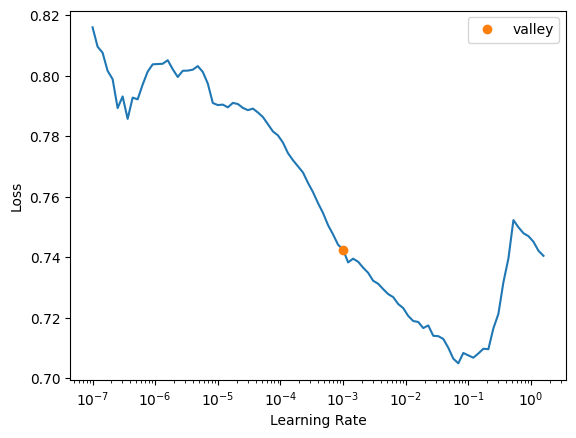

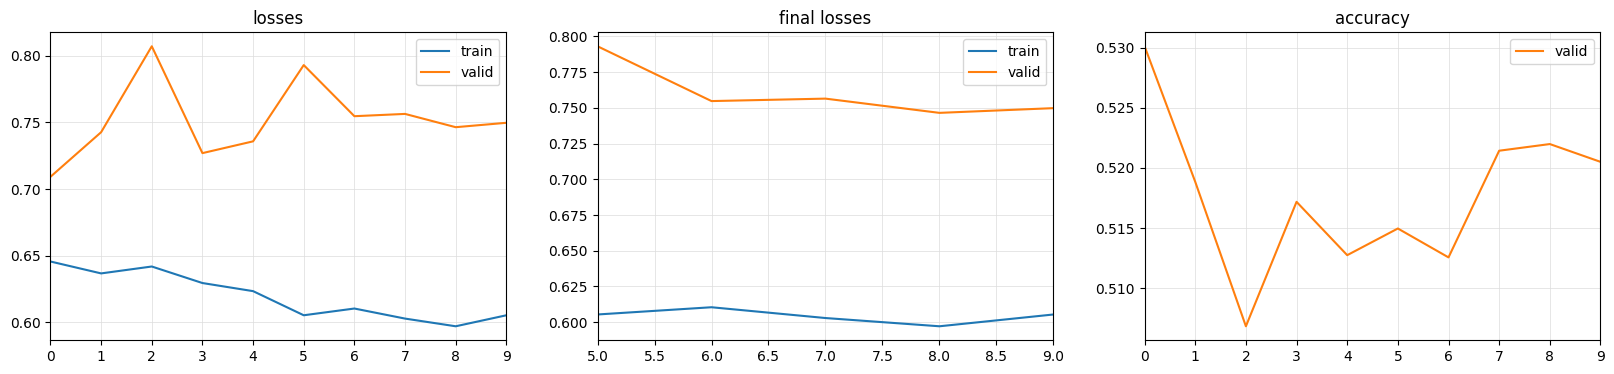

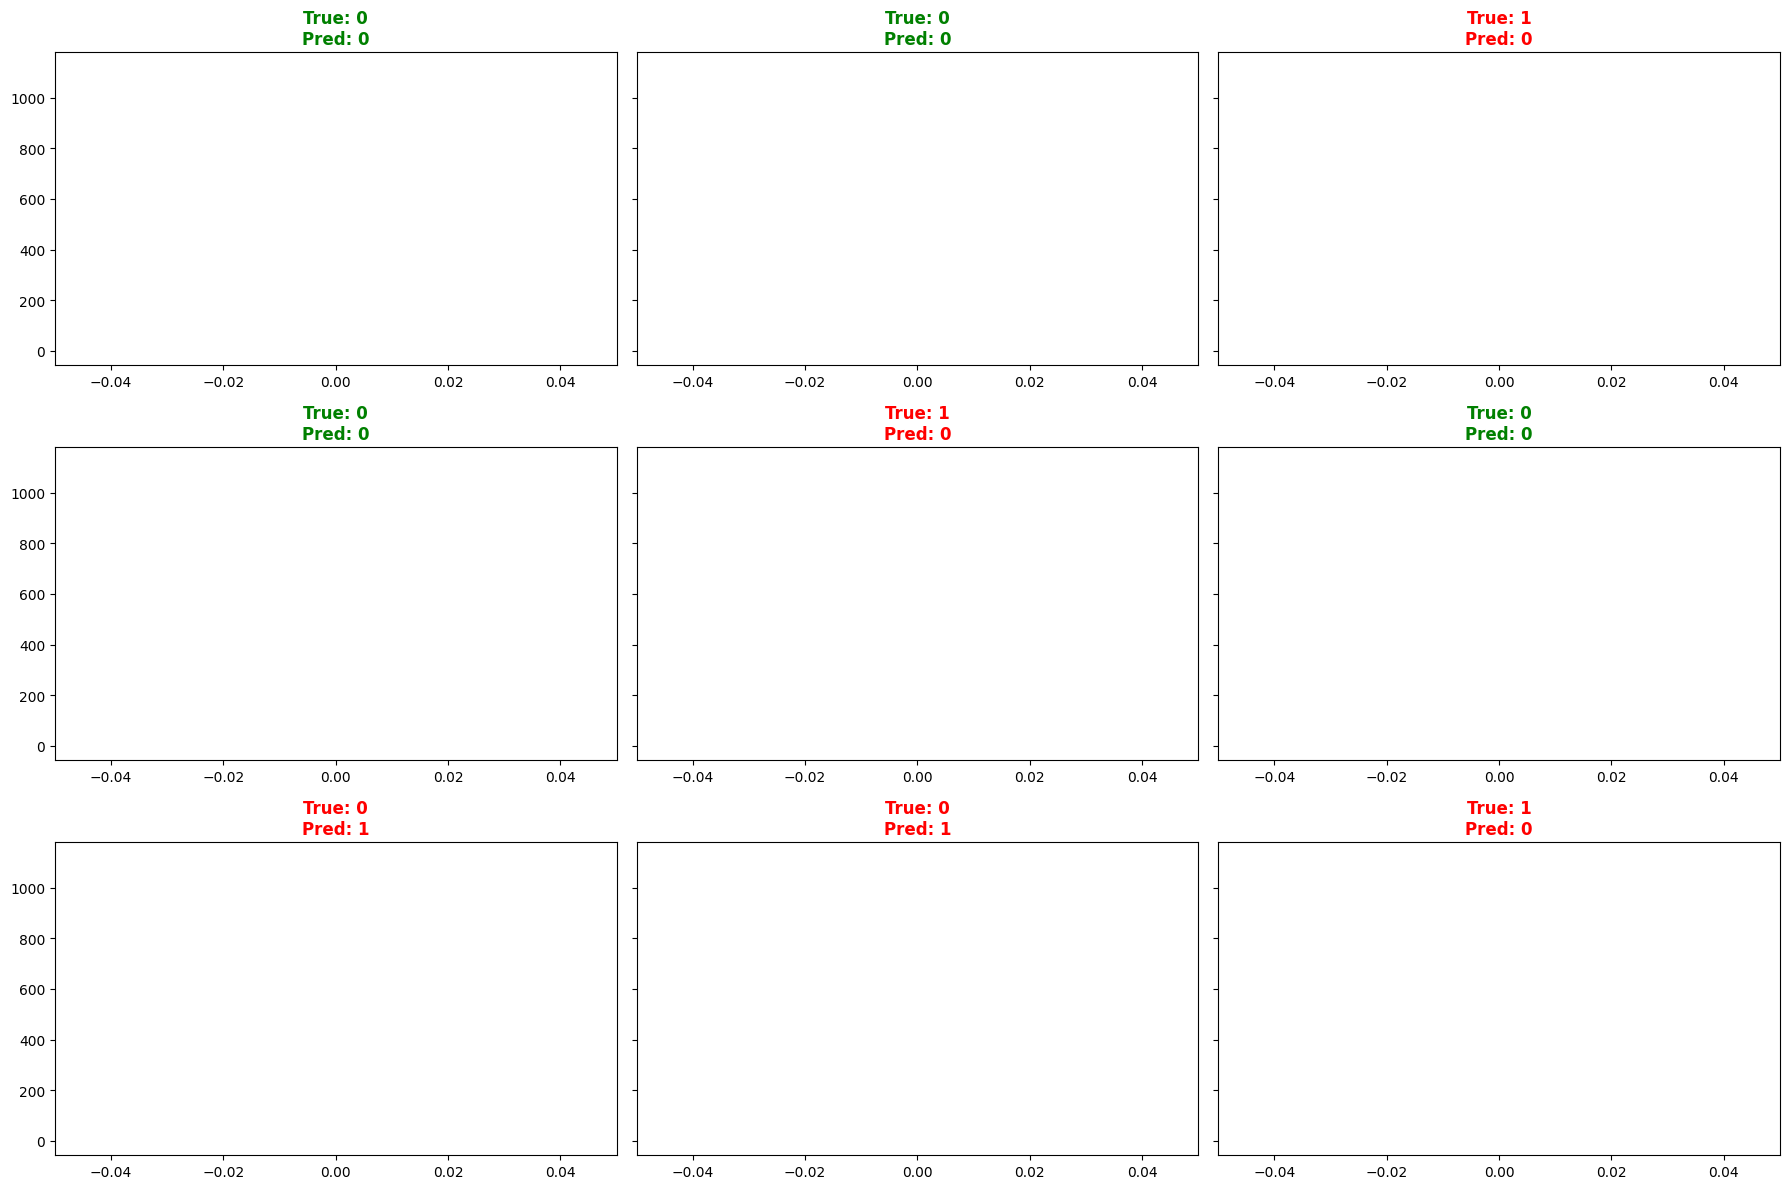

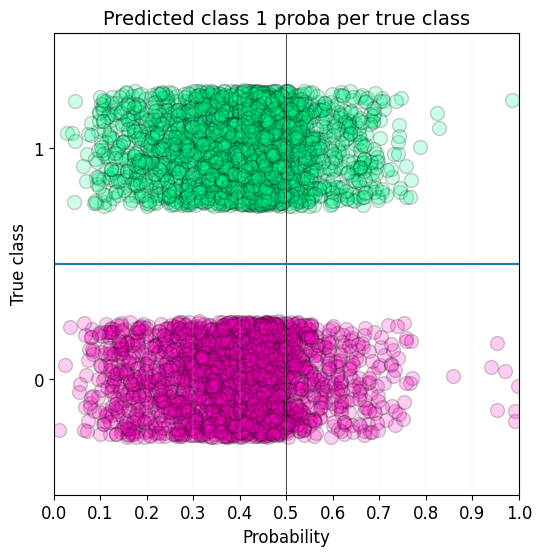

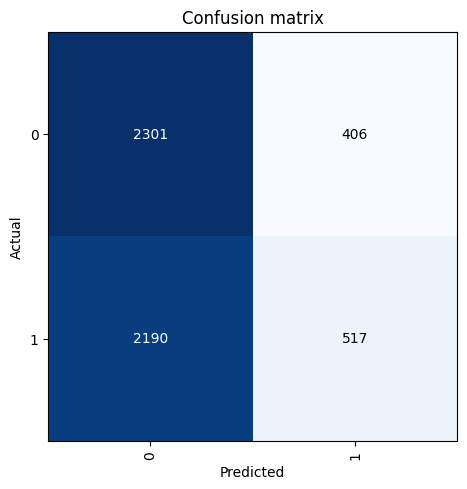

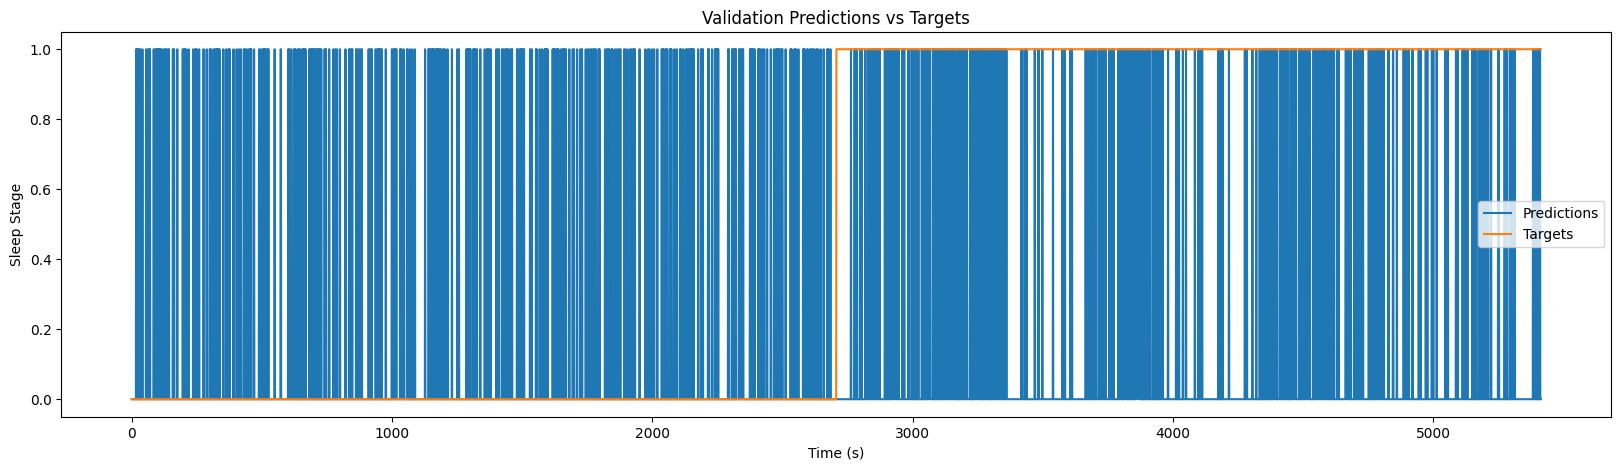

Processing file: n10.edf
New raw created successfully with EEG Ch only
filename: n10.txt
Shape of dataframe: (1111, 6)
Start time of annotations: 23:24:52
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=13194240
    Range : 0 ... 13194239 =      0.000 ... 25769.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=13194240
    Range : 0 ... 13194239 =      0.000 ... 25769.998 secs
Ready.
Features DataFrame created successfully with shape (25770, 30)
Balanced data has shape (5414, 30) (5414,)
Processing file: n2.edf
New raw created successfully with EEG Ch only
filename: n2.txt
Shape of dataframe: (1351, 5)
Start time of annotations: 22:19:06
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=16819200
    Range : 0 ... 16819199 =      0.000 ... 32849.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=16819200
    Range : 0 ... 16819199 =    

(20288, 30, 1)

(20288,)

(4601, 30, 1)

(4601,)

Counts by label: {0: 11699, 1: 8589}
Naive Accuracy: 57.66%


((#20288) [0,1,2,3,4,5,6,7,8,9...],
 (#4601) [20288,20289,20290,20291,20292,20293,20294,20295,20296,20297...])

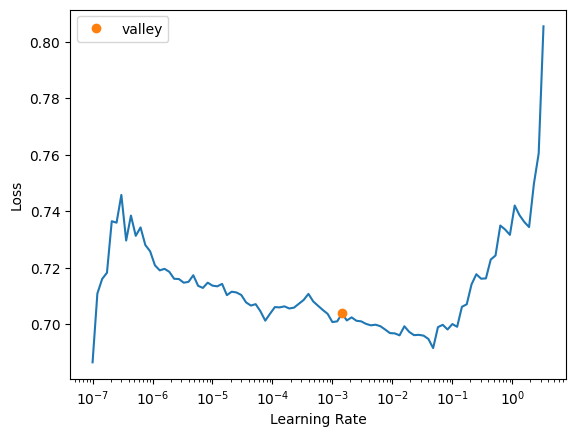

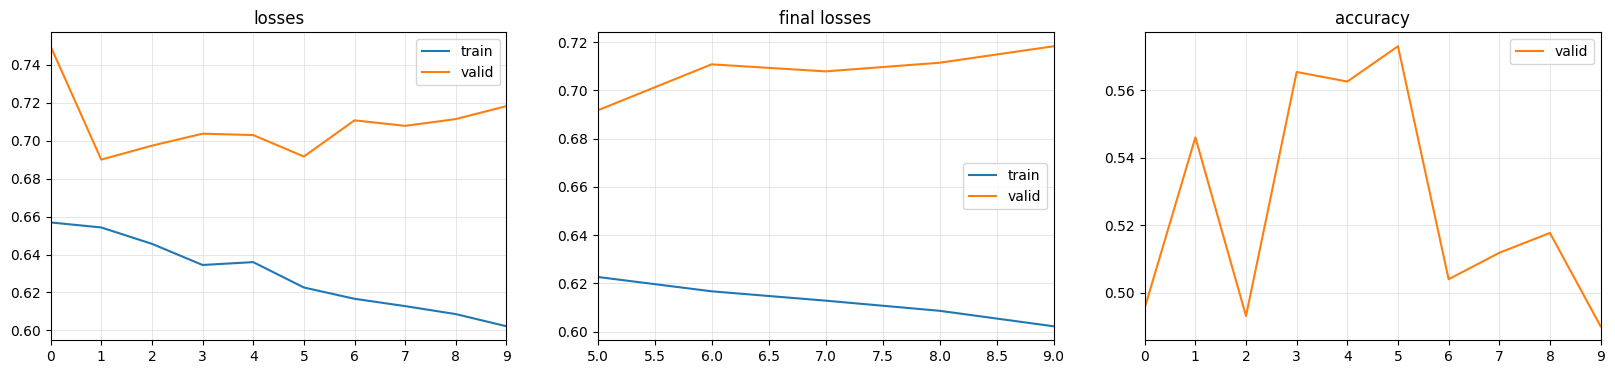

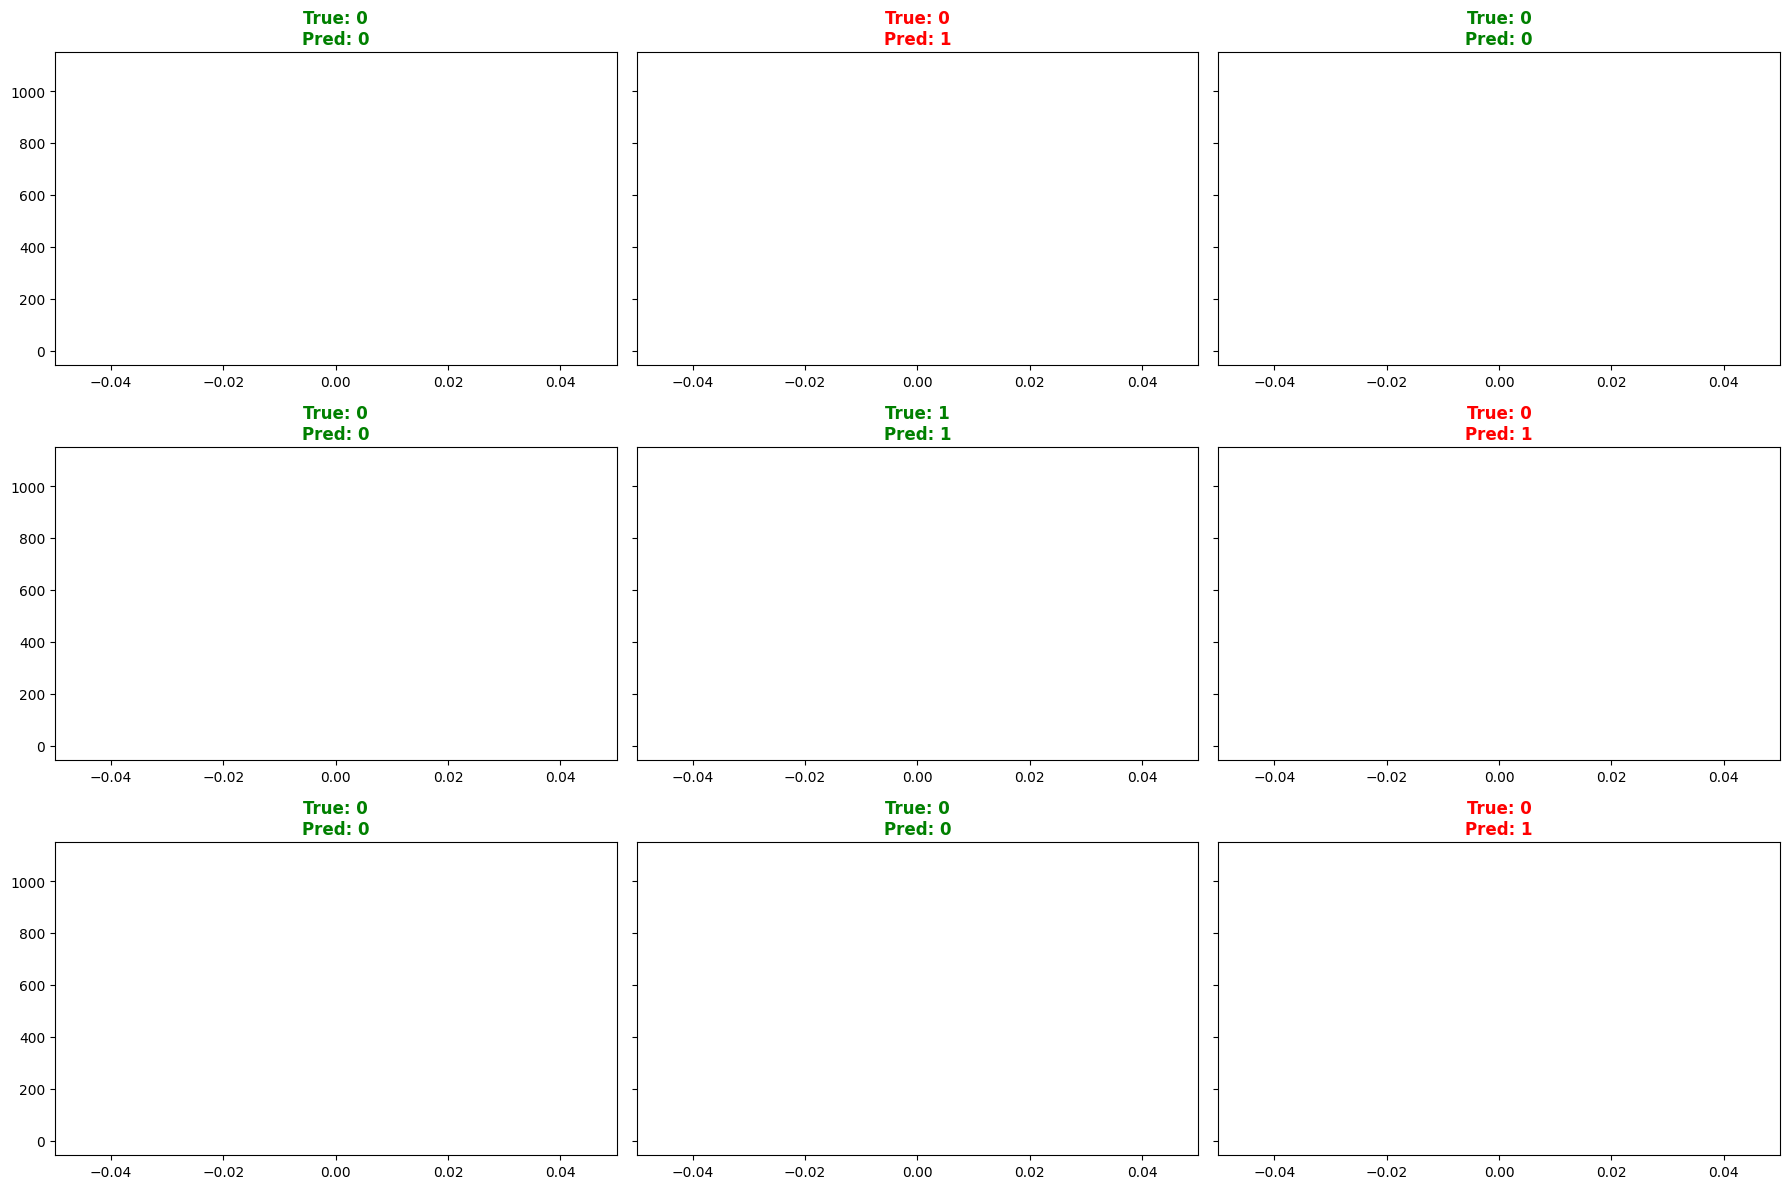

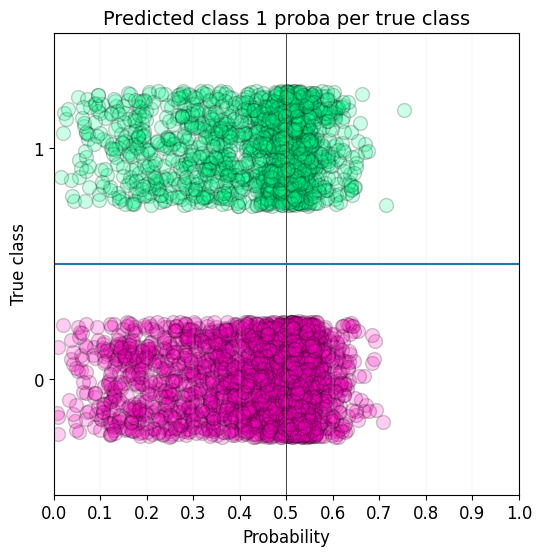

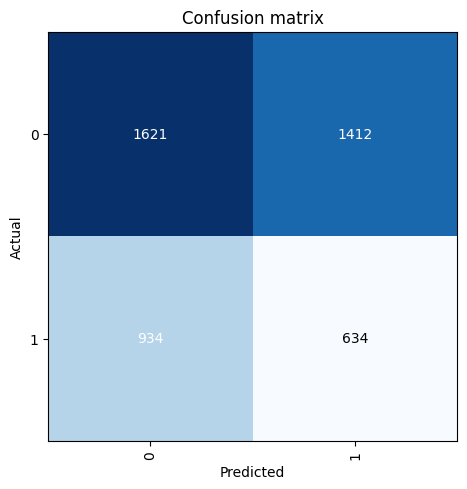

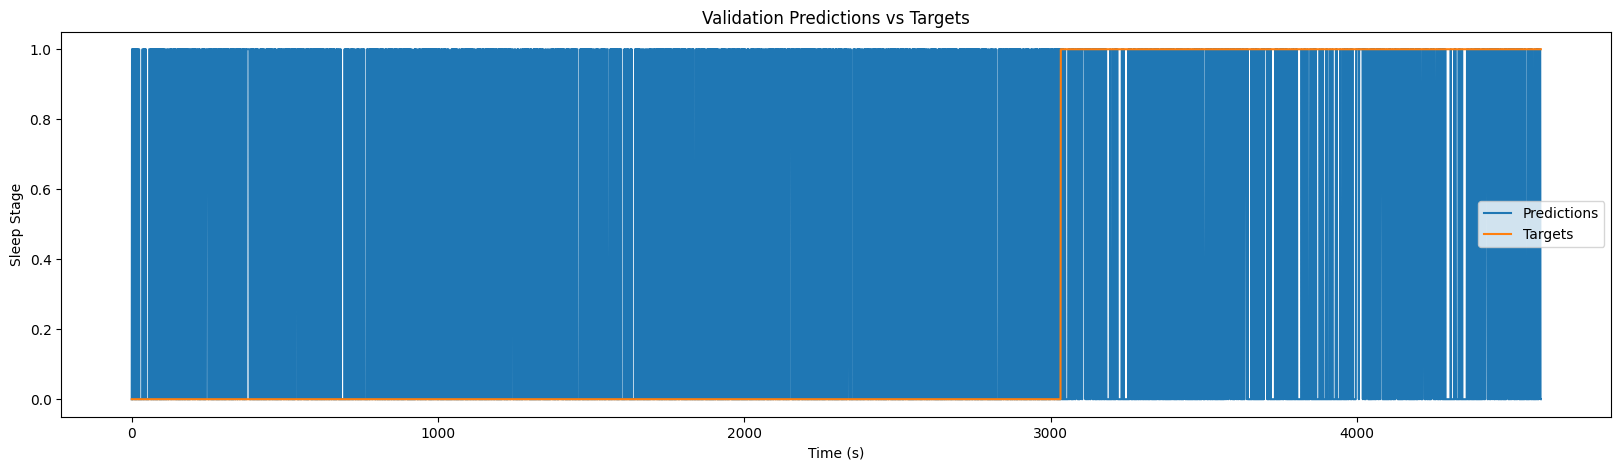

Processing file: n10.edf
New raw created successfully with EEG Ch only
filename: n10.txt
Shape of dataframe: (1111, 6)
Start time of annotations: 23:24:52
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=13194240
    Range : 0 ... 13194239 =      0.000 ... 25769.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=13194240
    Range : 0 ... 13194239 =      0.000 ... 25769.998 secs
Ready.
Features DataFrame created successfully with shape (25770, 30)
Balanced data has shape (5414, 30) (5414,)
Processing file: n11.edf
New raw created successfully with EEG Ch only
filename: n11.txt
Shape of dataframe: (1416, 6)
Start time of annotations: 22:37:16
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=16158720
    Range : 0 ... 16158719 =      0.000 ... 31559.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=16158720
    Range : 0 ... 16158719 =  

(21769, 30, 1)

(21769,)

(3120, 30, 1)

(3120,)

Counts by label: {0: 11617, 1: 10152}
Naive Accuracy: 53.36%


((#21769) [0,1,2,3,4,5,6,7,8,9...],
 (#3120) [21769,21770,21771,21772,21773,21774,21775,21776,21777,21778...])

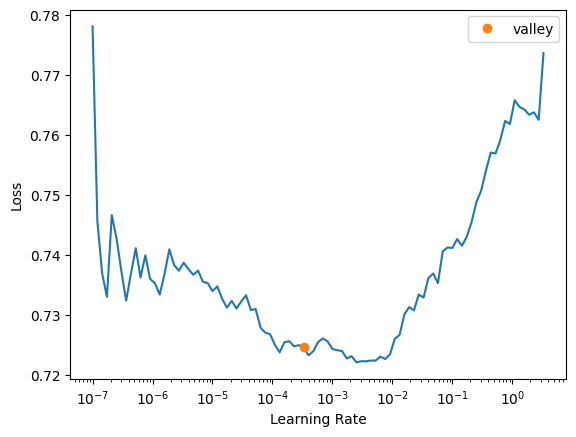

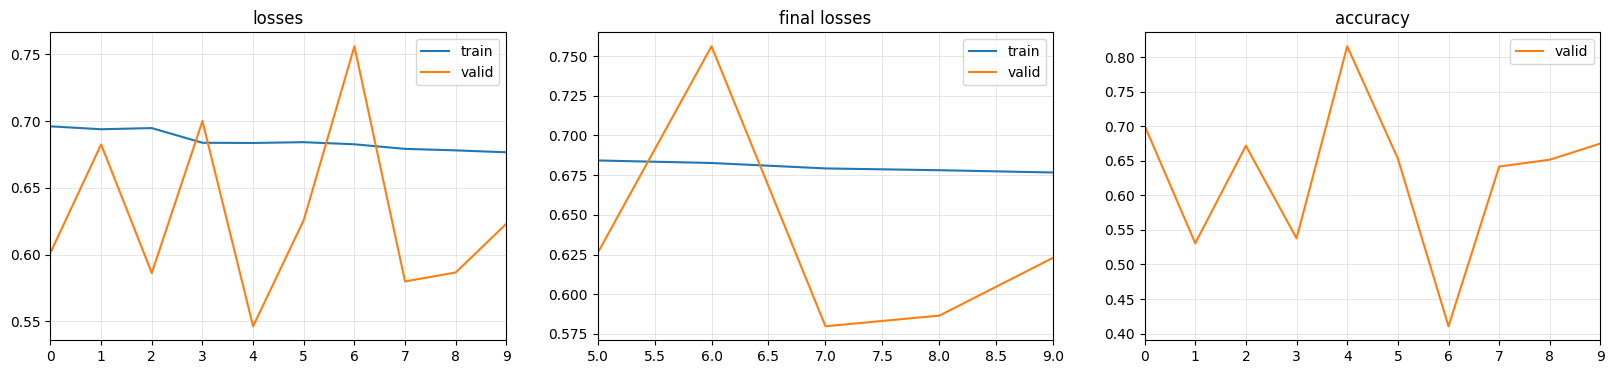

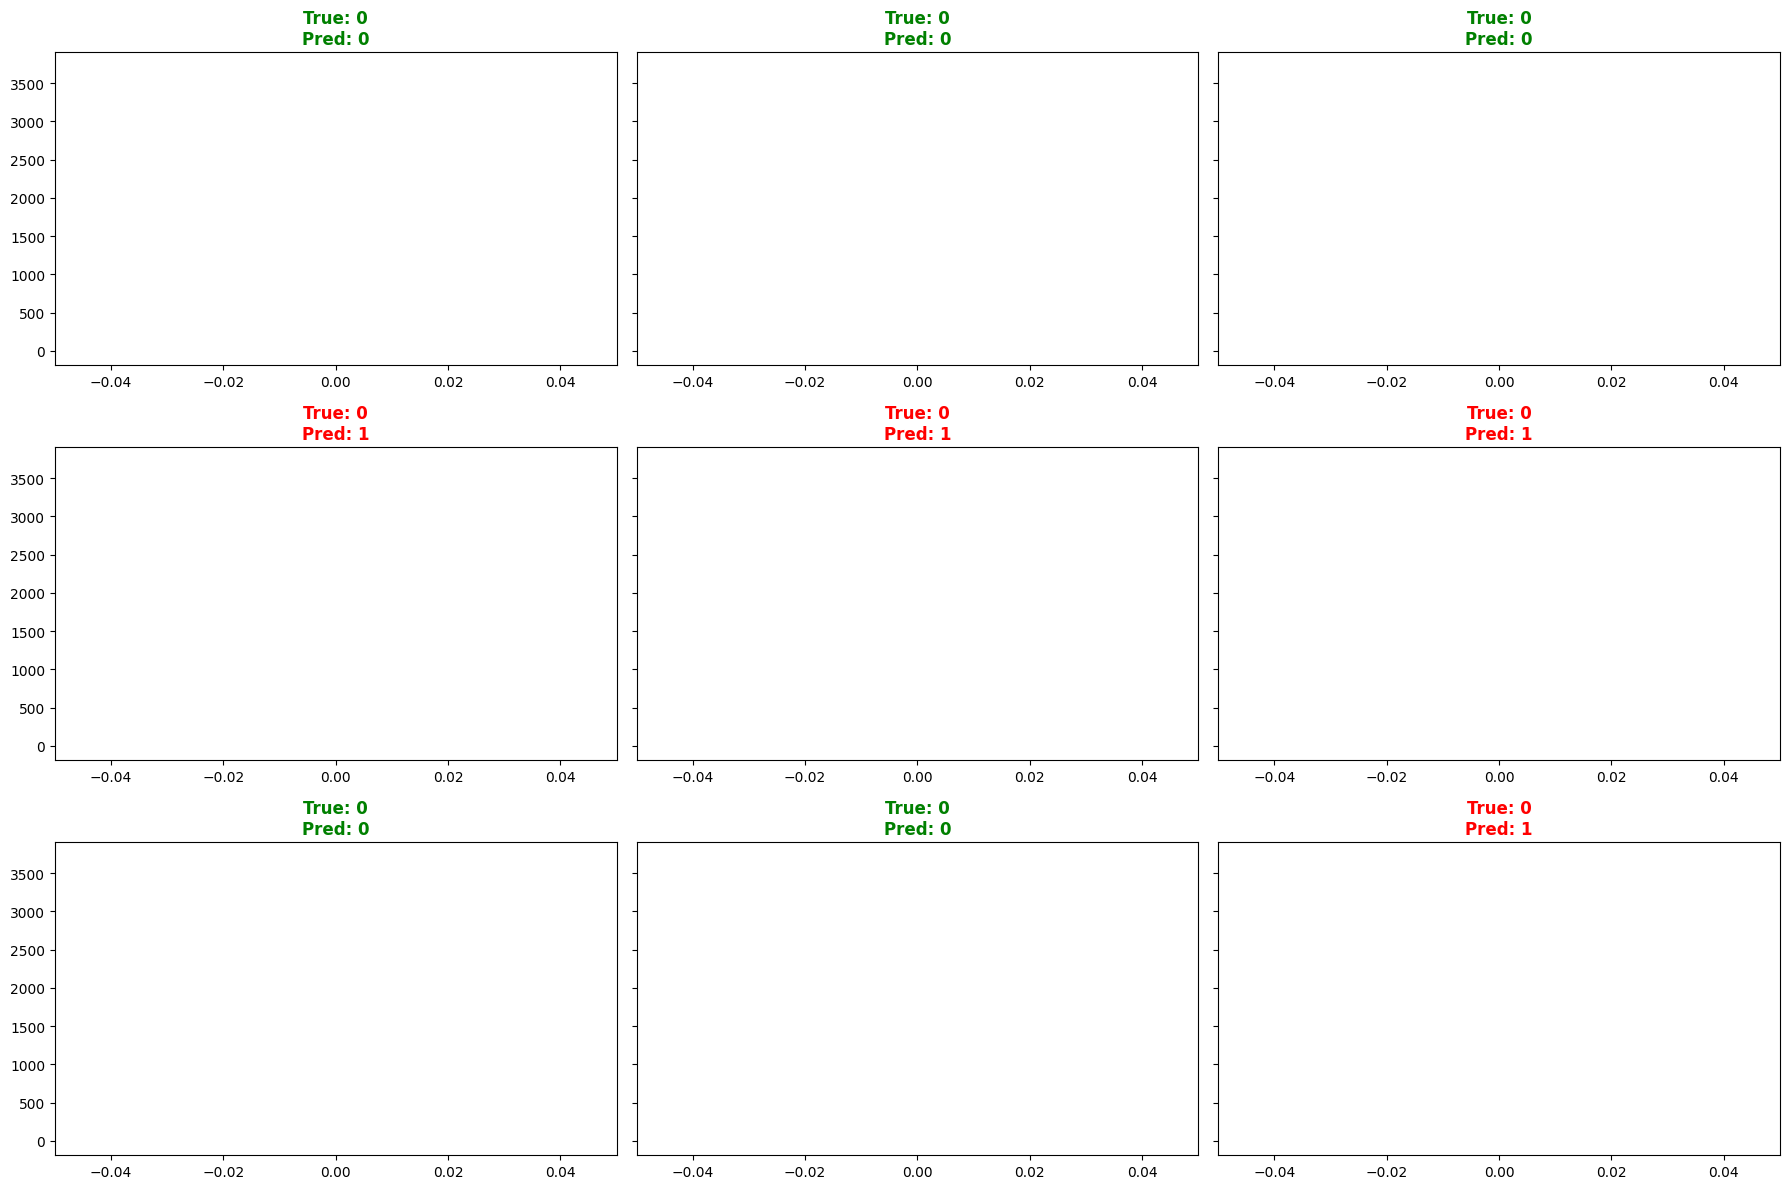

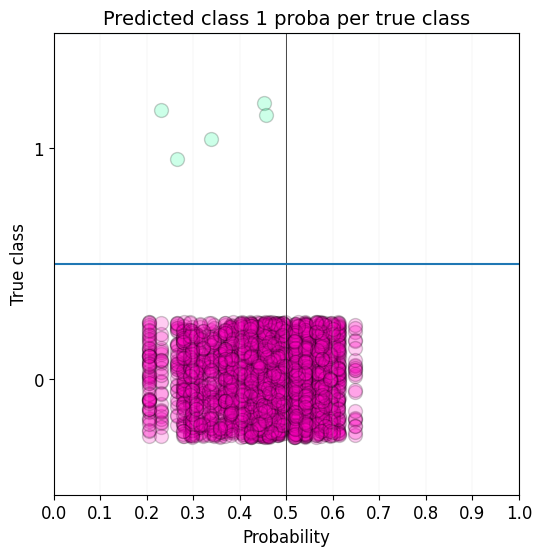

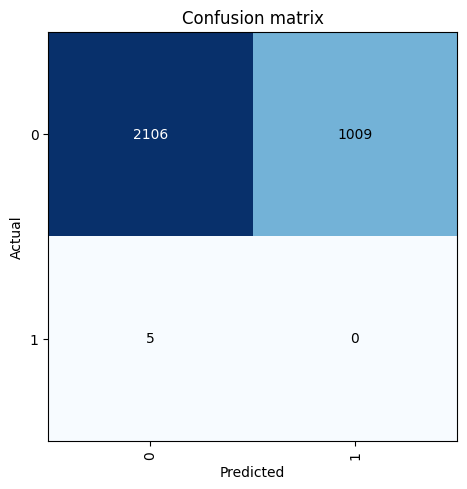

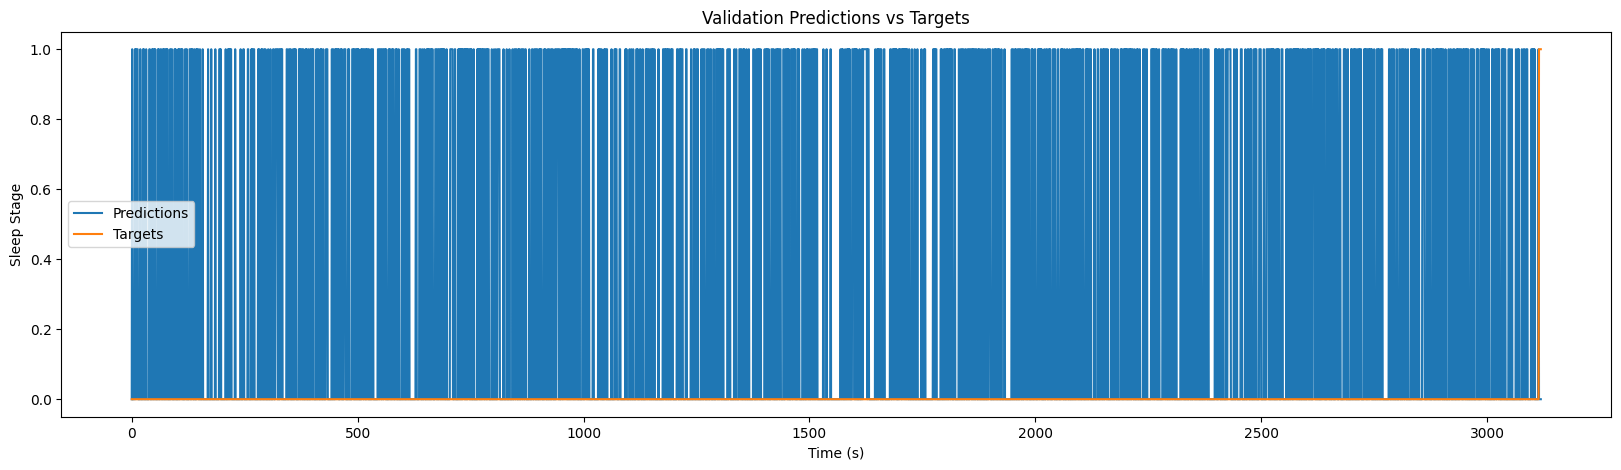

Processing file: n10.edf
New raw created successfully with EEG Ch only
filename: n10.txt
Shape of dataframe: (1111, 6)
Start time of annotations: 23:24:52
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=13194240
    Range : 0 ... 13194239 =      0.000 ... 25769.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=13194240
    Range : 0 ... 13194239 =      0.000 ... 25769.998 secs
Ready.
Features DataFrame created successfully with shape (25770, 30)
Balanced data has shape (5414, 30) (5414,)
Processing file: n11.edf
New raw created successfully with EEG Ch only
filename: n11.txt
Shape of dataframe: (1416, 6)
Start time of annotations: 22:37:16
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=16158720
    Range : 0 ... 16158719 =      0.000 ... 31559.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=16158720
    Range : 0 ... 16158719 =  

(20617, 30, 1)

(20617,)

(4272, 30, 1)

(4272,)

Counts by label: {0: 12596, 1: 8021}
Naive Accuracy: 61.10%


((#20617) [0,1,2,3,4,5,6,7,8,9...],
 (#4272) [20617,20618,20619,20620,20621,20622,20623,20624,20625,20626...])

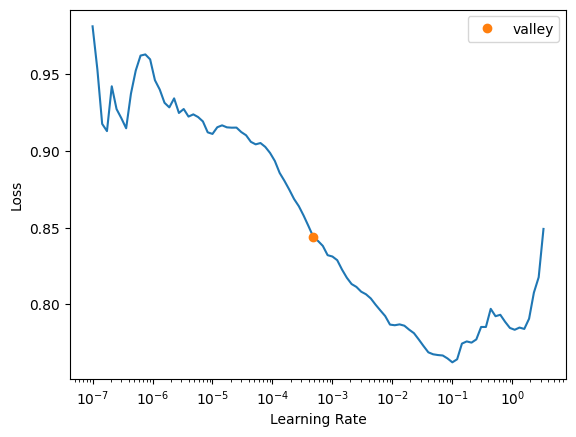

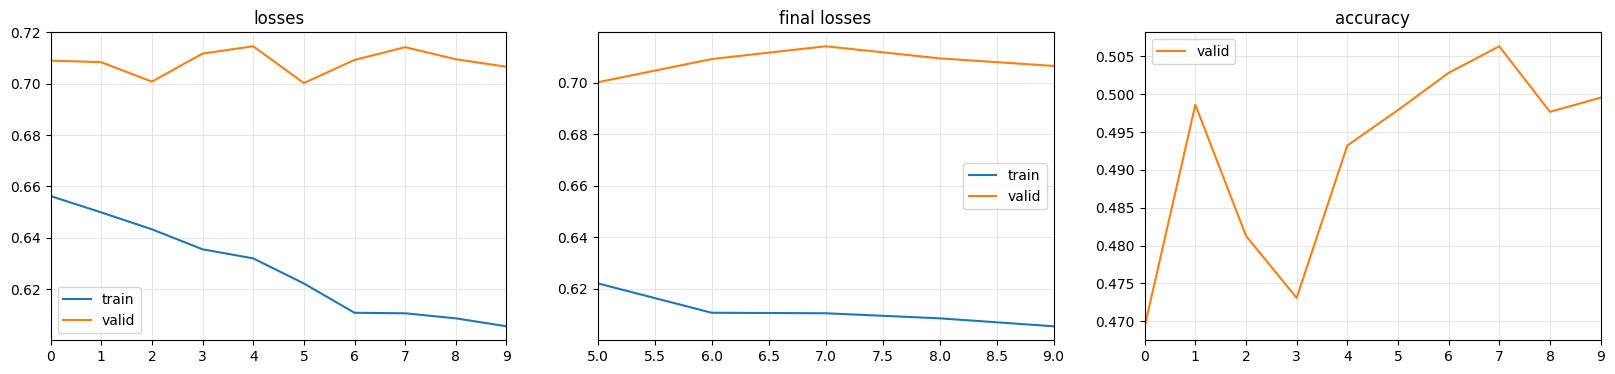

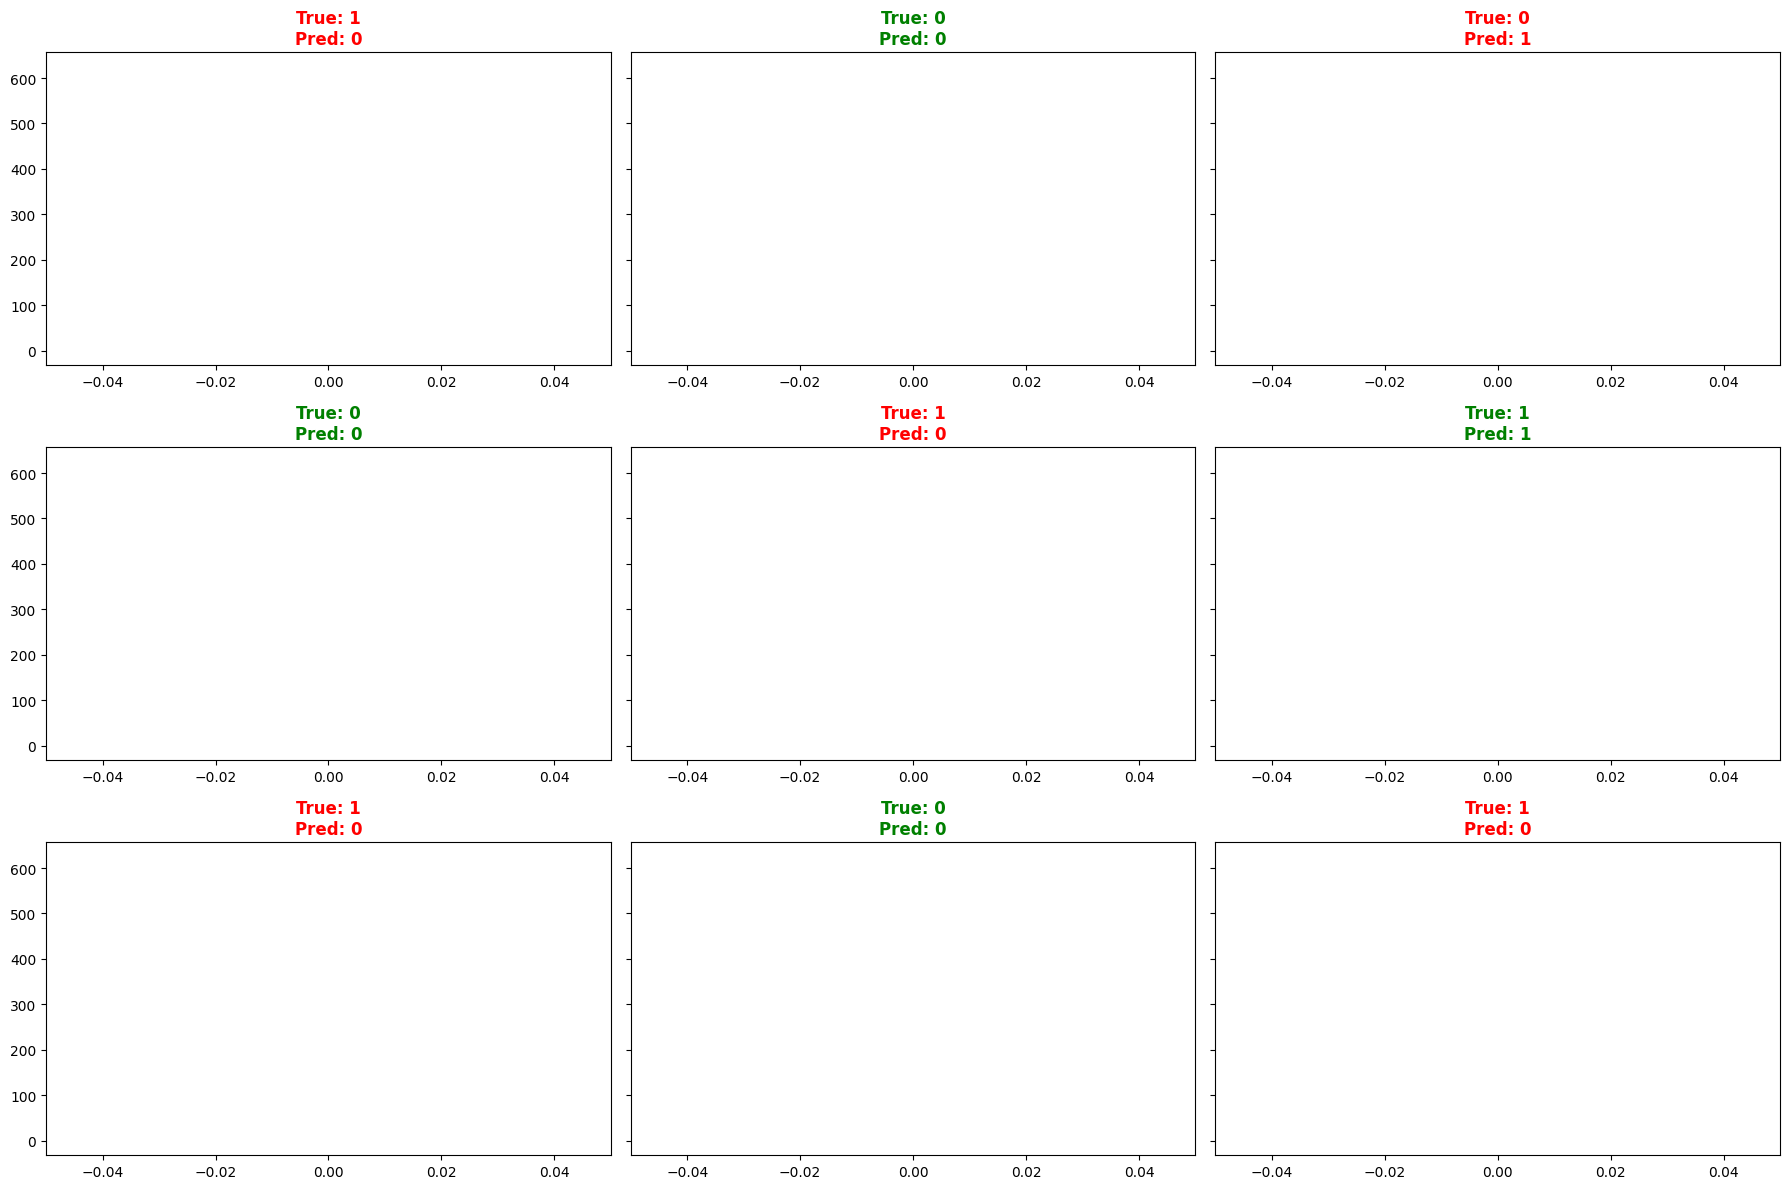

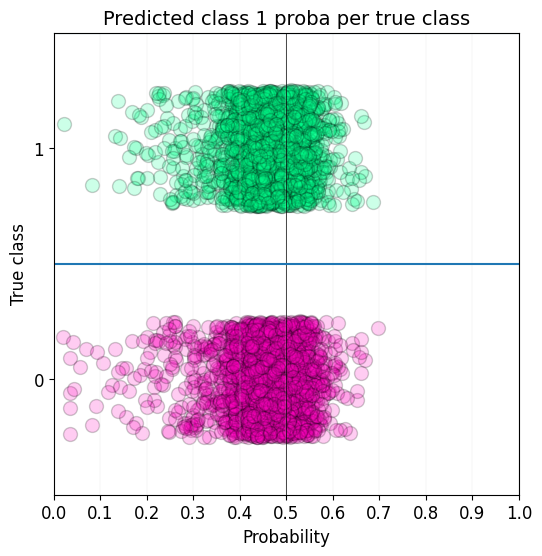

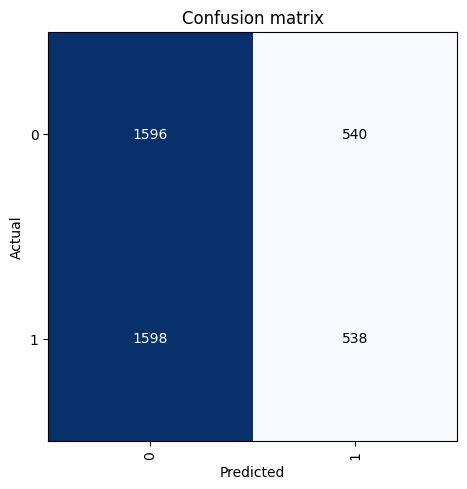

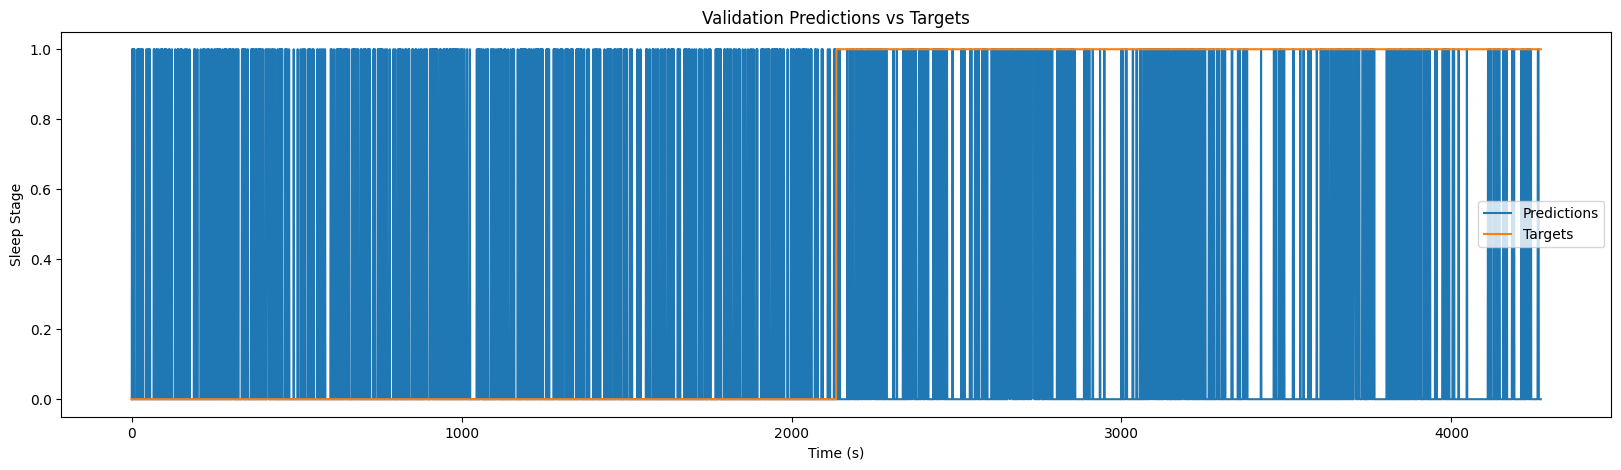

Processing file: n10.edf
New raw created successfully with EEG Ch only
filename: n10.txt
Shape of dataframe: (1111, 6)
Start time of annotations: 23:24:52
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=13194240
    Range : 0 ... 13194239 =      0.000 ... 25769.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=13194240
    Range : 0 ... 13194239 =      0.000 ... 25769.998 secs
Ready.
Features DataFrame created successfully with shape (25770, 30)
Balanced data has shape (5414, 30) (5414,)
Processing file: n11.edf
New raw created successfully with EEG Ch only
filename: n11.txt
Shape of dataframe: (1416, 6)
Start time of annotations: 22:37:16
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=16158720
    Range : 0 ... 16158719 =      0.000 ... 31559.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=16158720
    Range : 0 ... 16158719 =  

(17407, 30, 1)

(17407,)

(7482, 30, 1)

(7482,)

Counts by label: {0: 10991, 1: 6416}
Naive Accuracy: 63.14%


((#17407) [0,1,2,3,4,5,6,7,8,9...],
 (#7482) [17407,17408,17409,17410,17411,17412,17413,17414,17415,17416...])

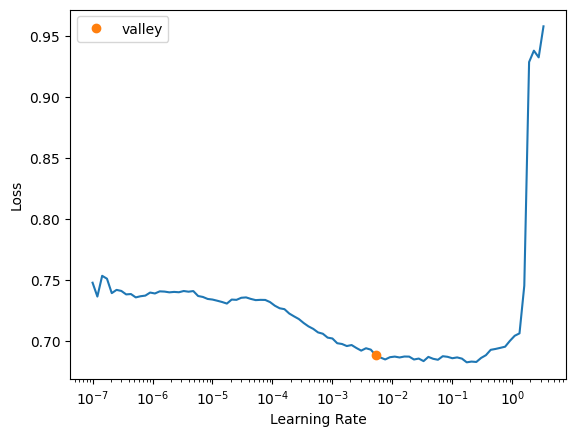

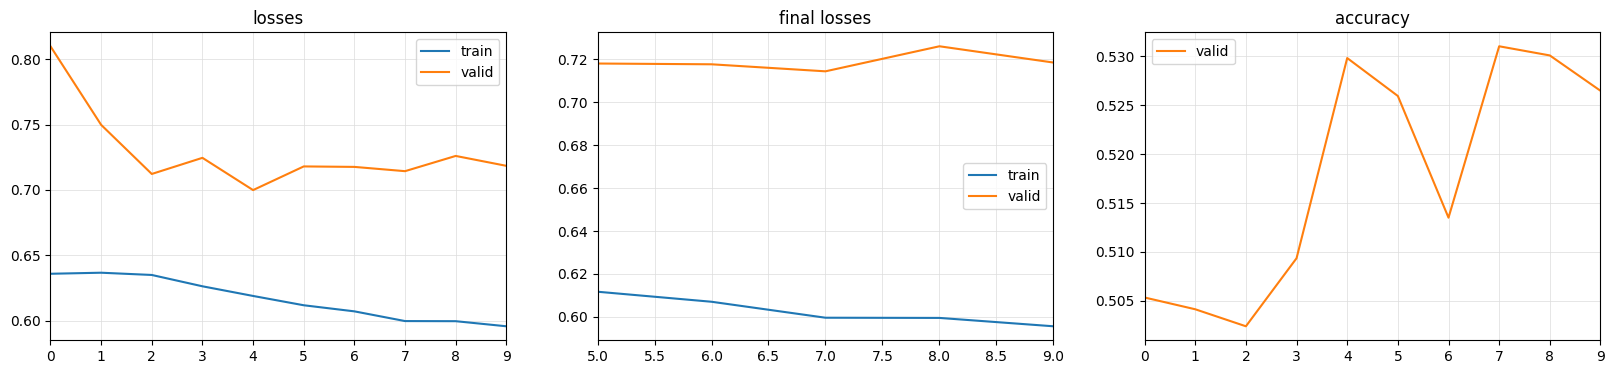

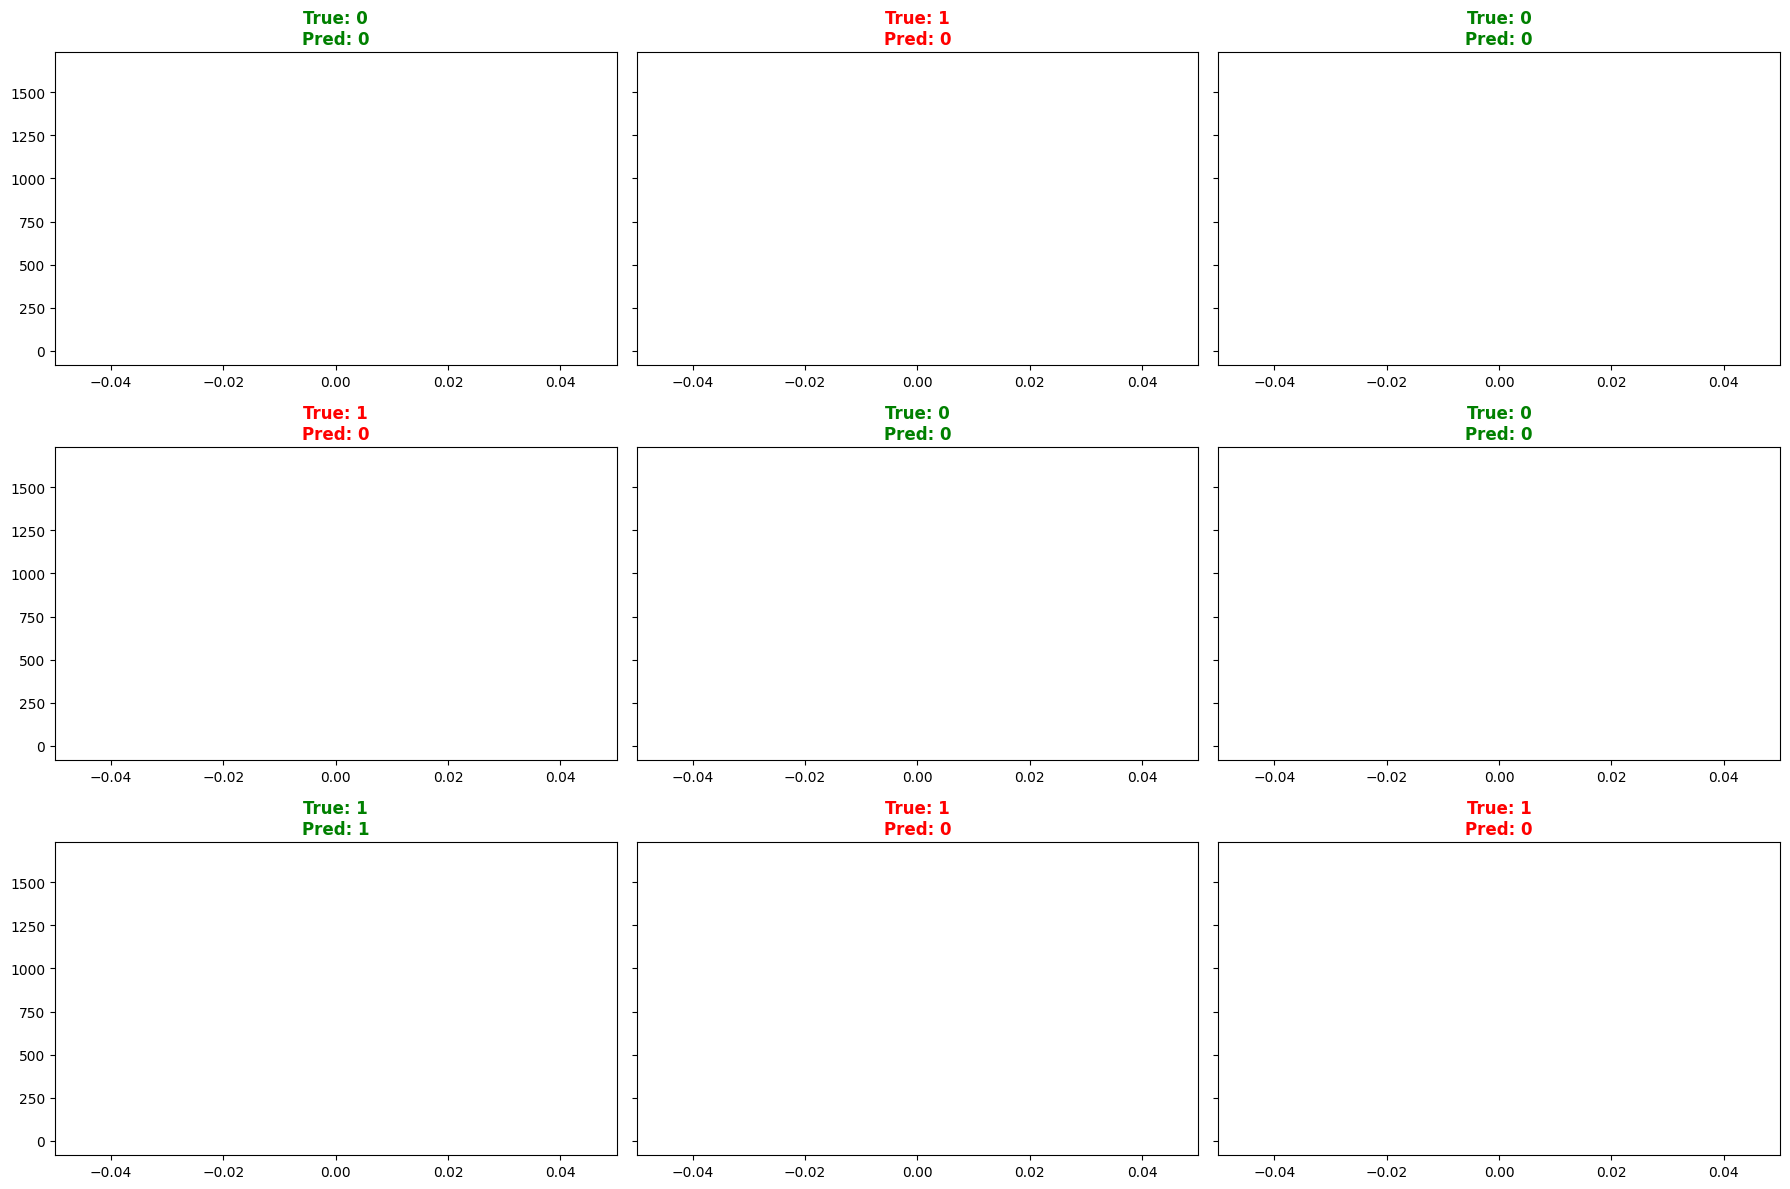

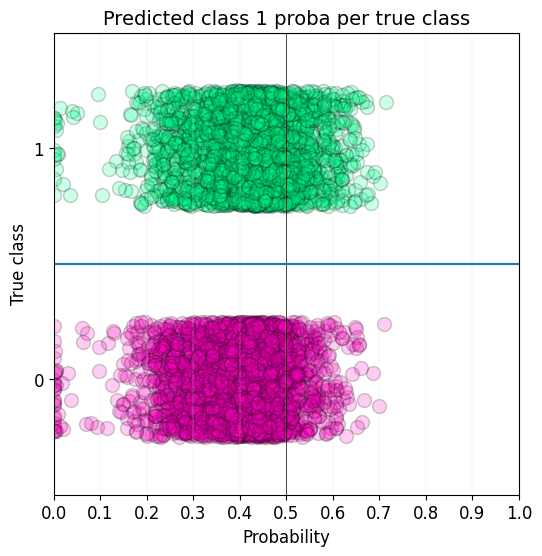

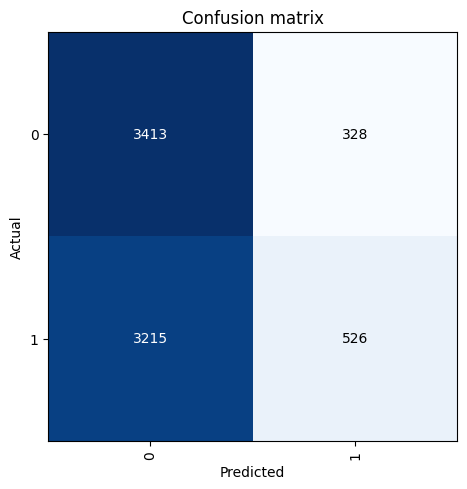

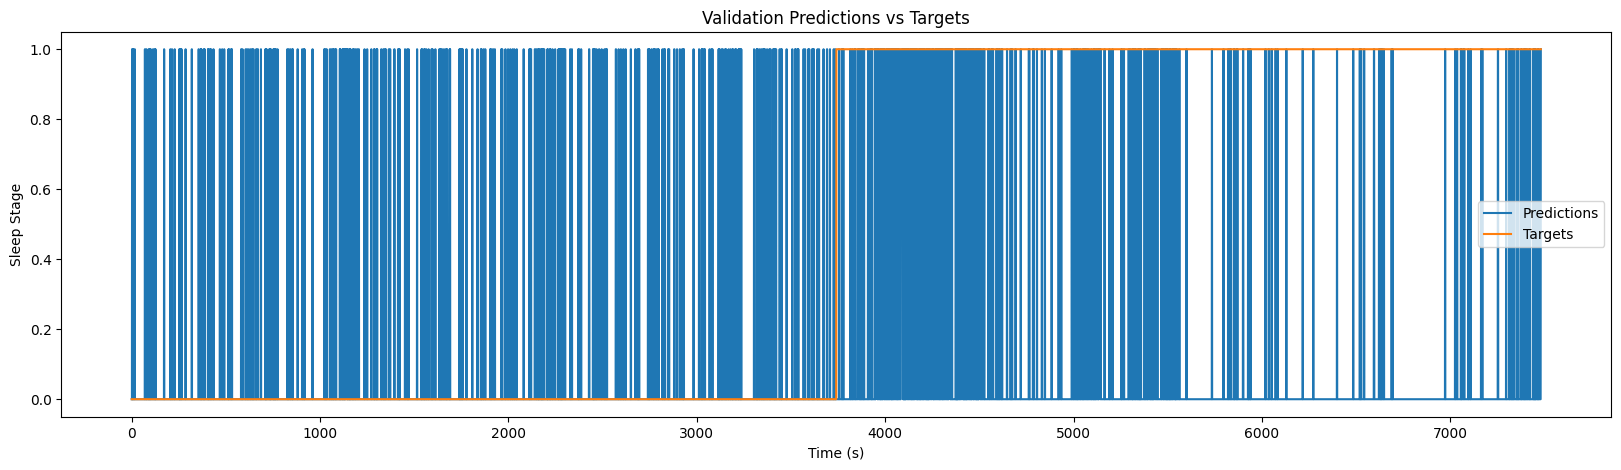

In [ ]:
# train the model on these edf files: n1, n2, n3, n5, n10, n11
train_files = ['n2.edf', 'n3.edf', 'n5.edf', 'n10.edf', 'n11.edf']

# Filter the edf_files list if it has the name in the train_files list
filtered_edf_files = [file for file in edf_files if any(train_file in file for train_file in train_files)]

get_train_valid_splits(filtered_edf_files)

# Train with 4 Classes

Processing file: n11.edf
New raw created successfully with EEG Ch only
filename: n11.txt
Shape of dataframe: (1416, 6)
Start time of annotations: 22:37:16
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=16158720
    Range : 0 ... 16158719 =      0.000 ... 31559.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=16158720
    Range : 0 ... 16158719 =      0.000 ... 31559.998 secs
Ready.
Features DataFrame created successfully with shape (31560, 30)
Balanced data has shape (4601, 30) (4601,)
Processing file: n2.edf
New raw created successfully with EEG Ch only
filename: n2.txt
Shape of dataframe: (1351, 5)
Start time of annotations: 22:19:06
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=16819200
    Range : 0 ... 16819199 =      0.000 ... 32849.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=16819200
    Range : 0 ... 16819199 =    

(19475, 30, 1)

(19475,)

(5414, 30, 1)

(5414,)

Counts by label: {0: 12025, 3: 1857, 1: 4379, 2: 1214}
Naive Accuracy: 61.75%


((#19475) [0,1,2,3,4,5,6,7,8,9...],
 (#5414) [19475,19476,19477,19478,19479,19480,19481,19482,19483,19484...])

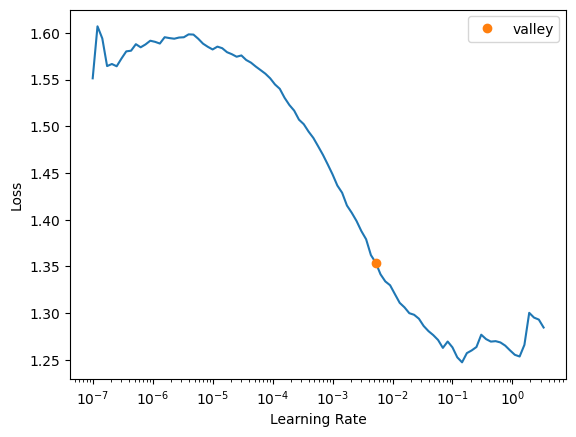

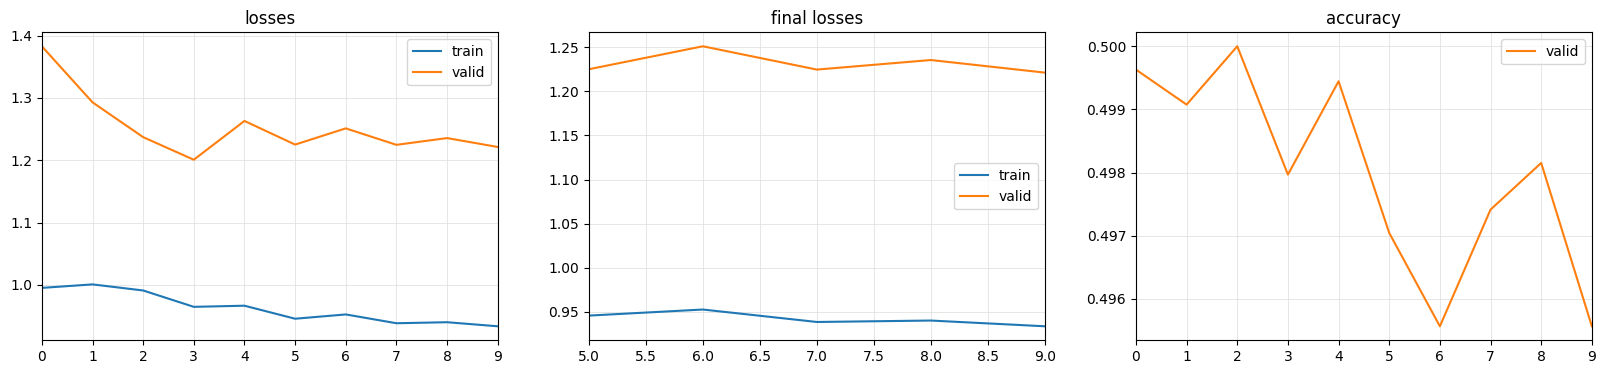

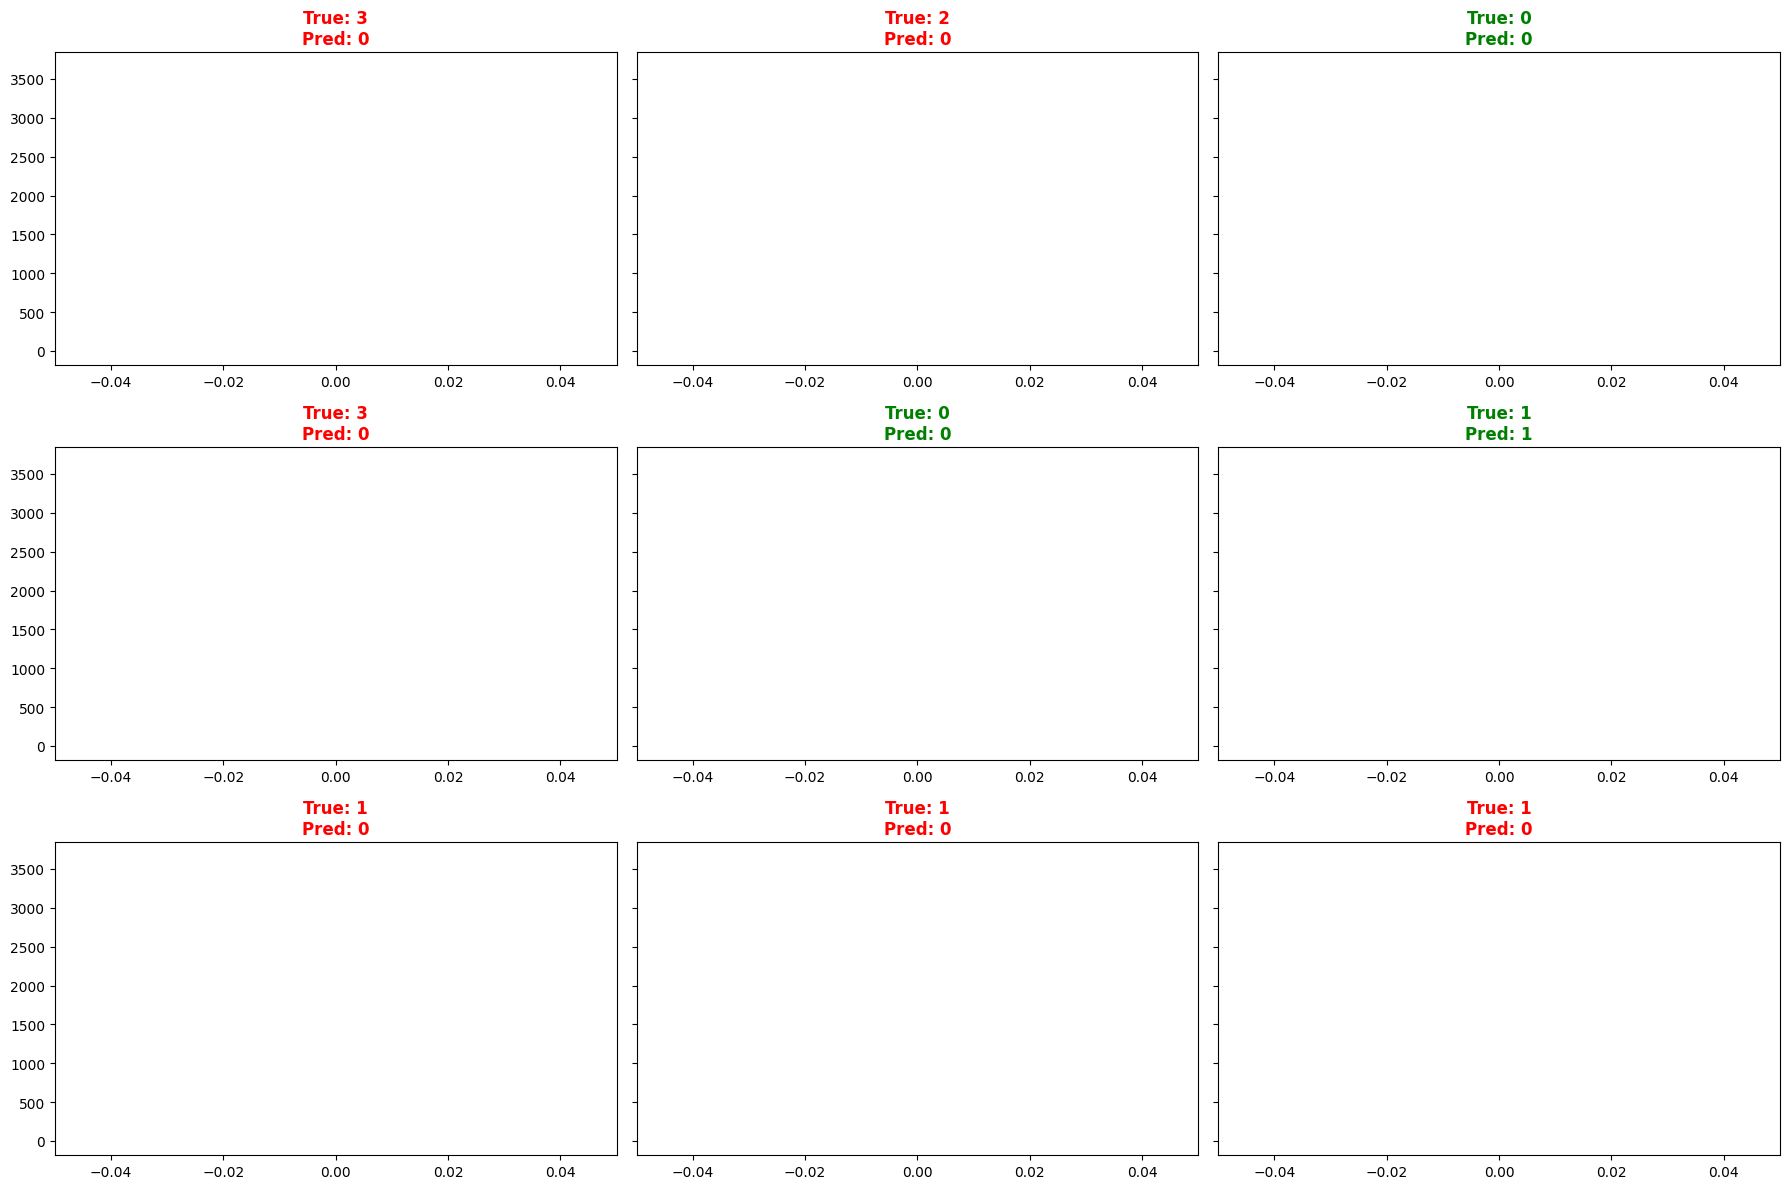

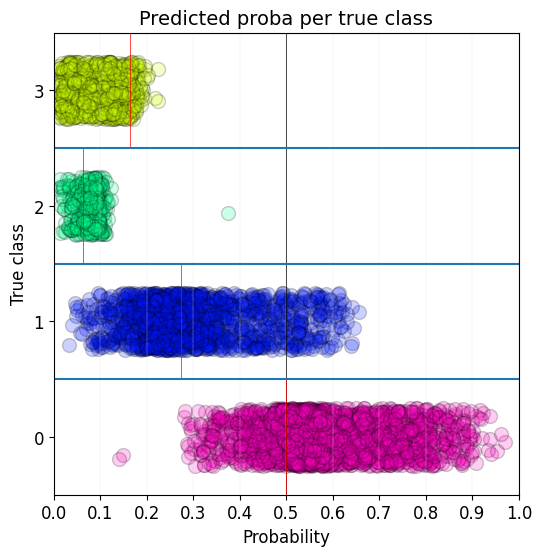

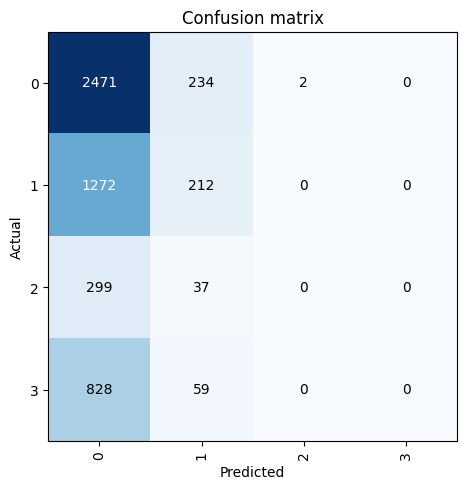

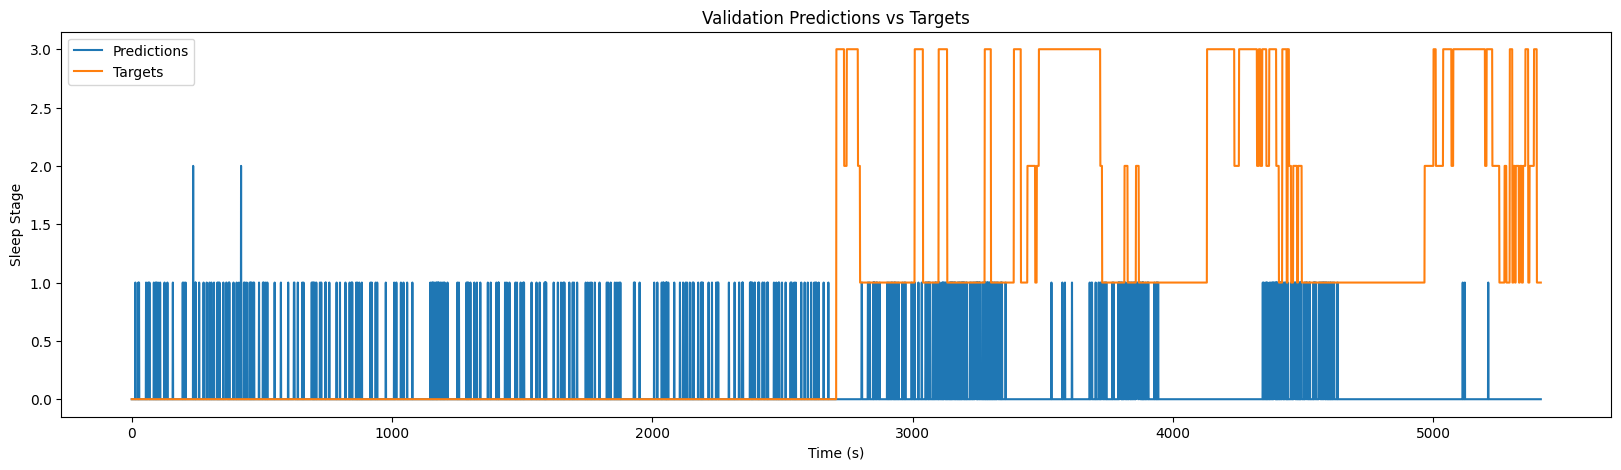

Processing file: n10.edf
New raw created successfully with EEG Ch only
filename: n10.txt
Shape of dataframe: (1111, 6)
Start time of annotations: 23:24:52
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=13194240
    Range : 0 ... 13194239 =      0.000 ... 25769.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=13194240
    Range : 0 ... 13194239 =      0.000 ... 25769.998 secs
Ready.
Features DataFrame created successfully with shape (25770, 30)
Balanced data has shape (5414, 30) (5414,)
Processing file: n2.edf
New raw created successfully with EEG Ch only
filename: n2.txt
Shape of dataframe: (1351, 5)
Start time of annotations: 22:19:06
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=16819200
    Range : 0 ... 16819199 =      0.000 ... 32849.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=16819200
    Range : 0 ... 16819199 =    

(20288, 30, 1)

(20288,)

(4601, 30, 1)

(4601,)

Counts by label: {0: 11699, 3: 2383, 2: 1268, 1: 4938}
Naive Accuracy: 57.66%


((#20288) [0,1,2,3,4,5,6,7,8,9...],
 (#4601) [20288,20289,20290,20291,20292,20293,20294,20295,20296,20297...])

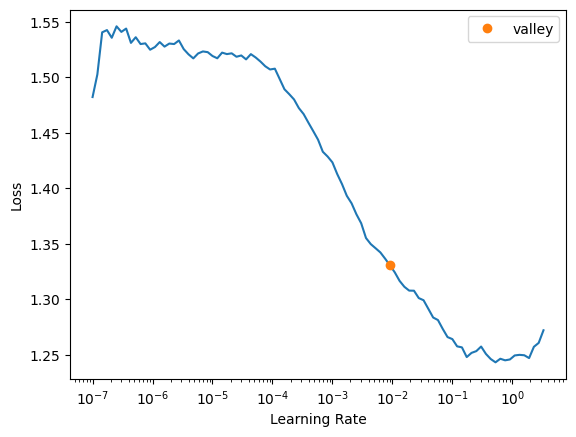

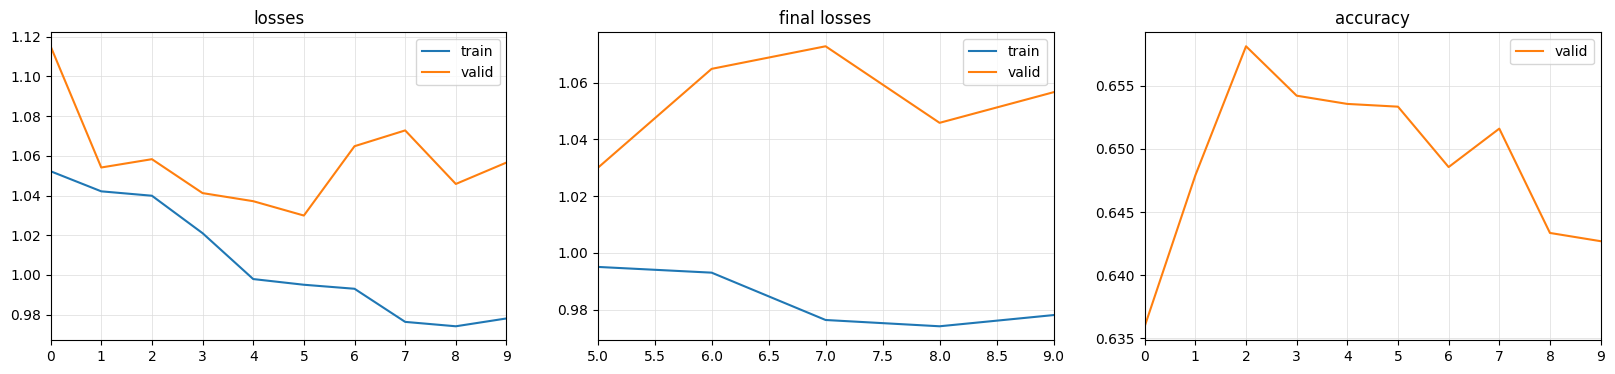

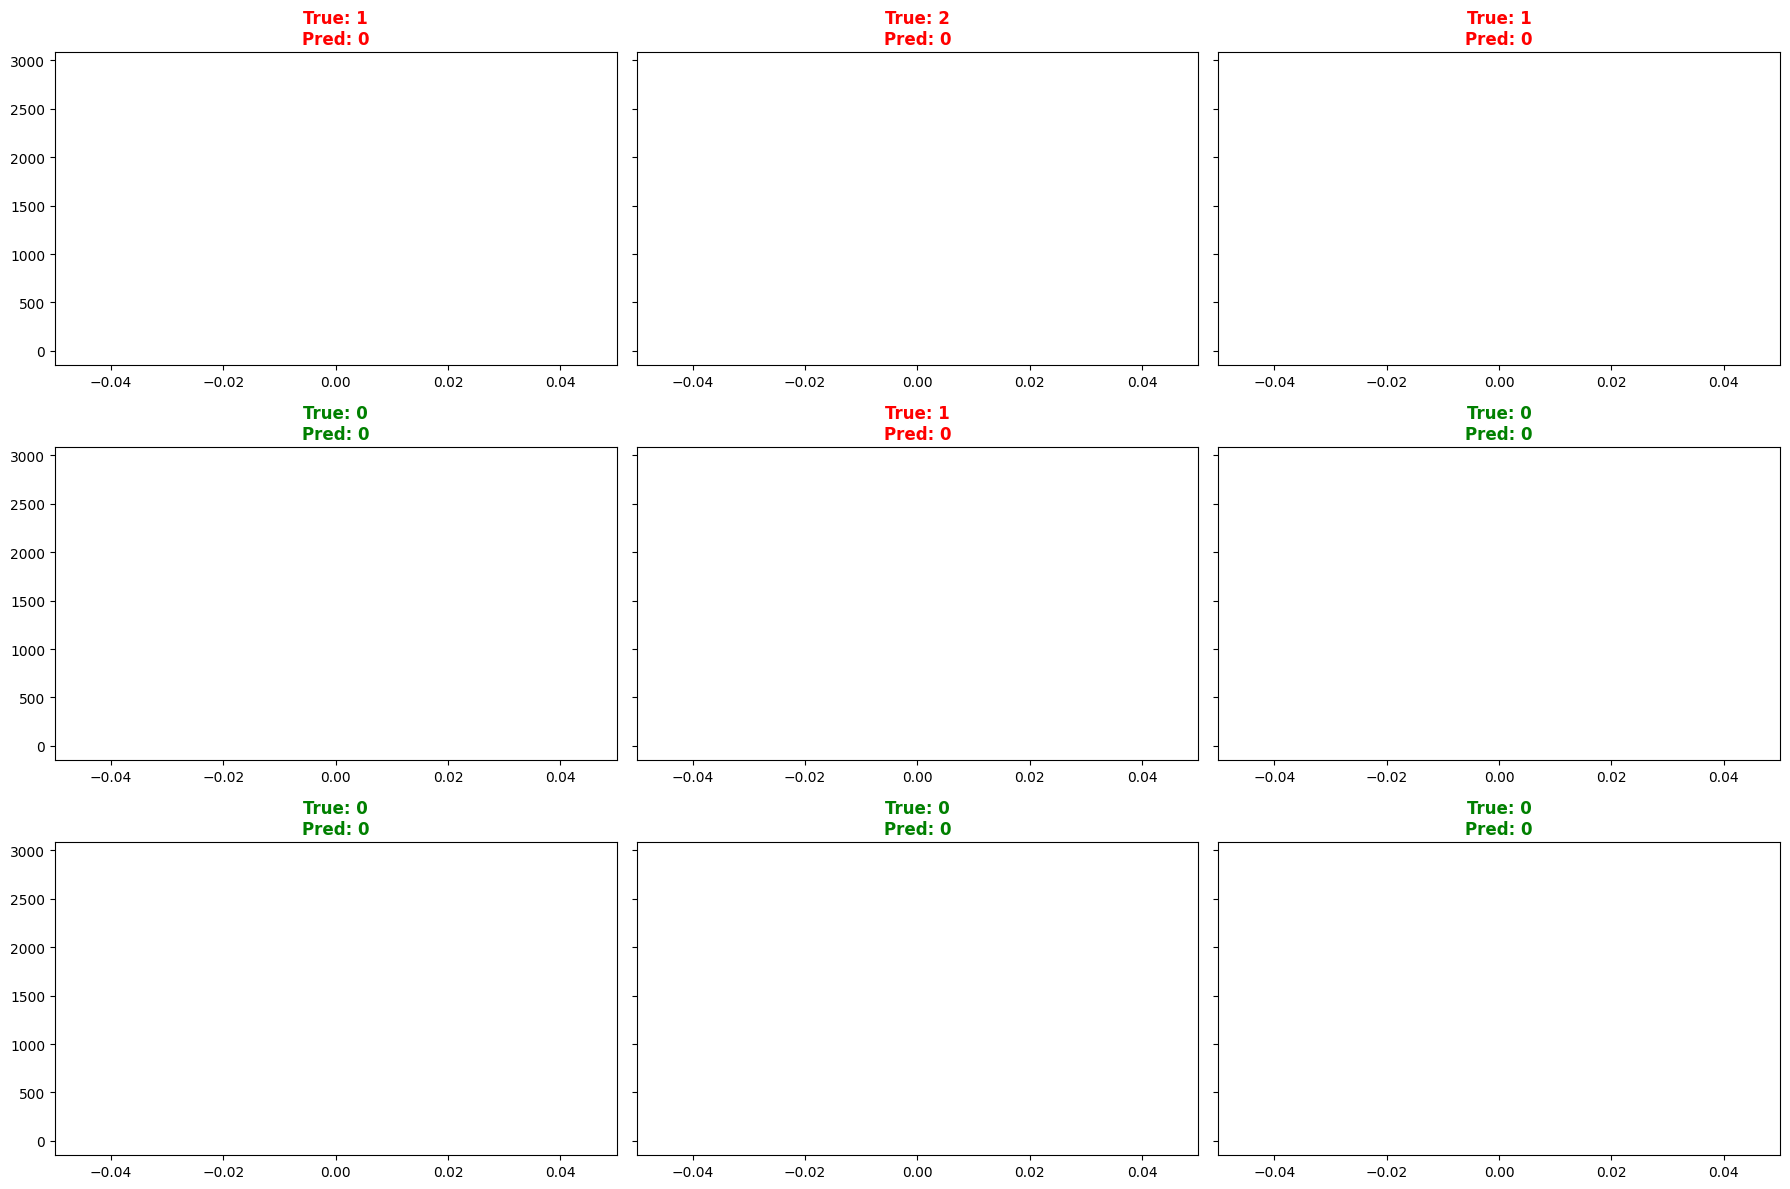

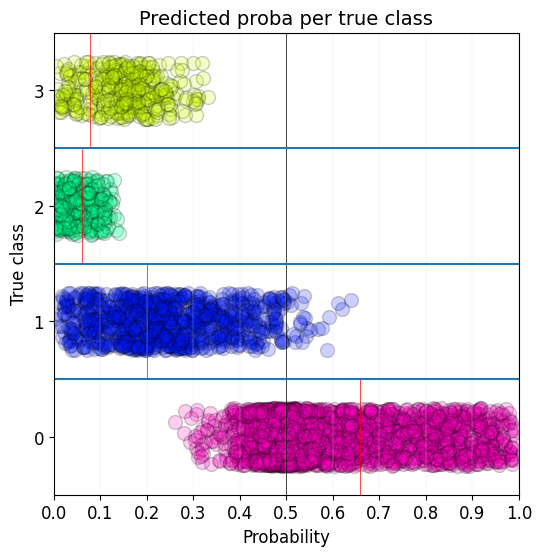

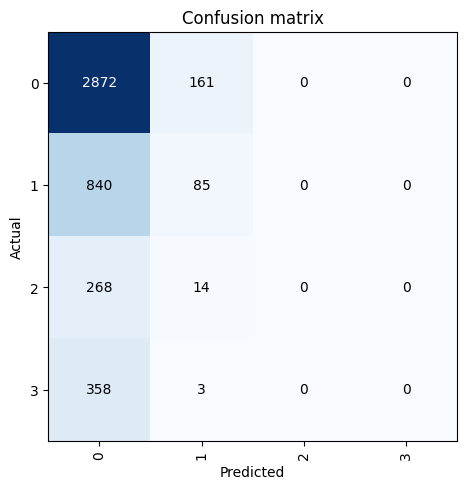

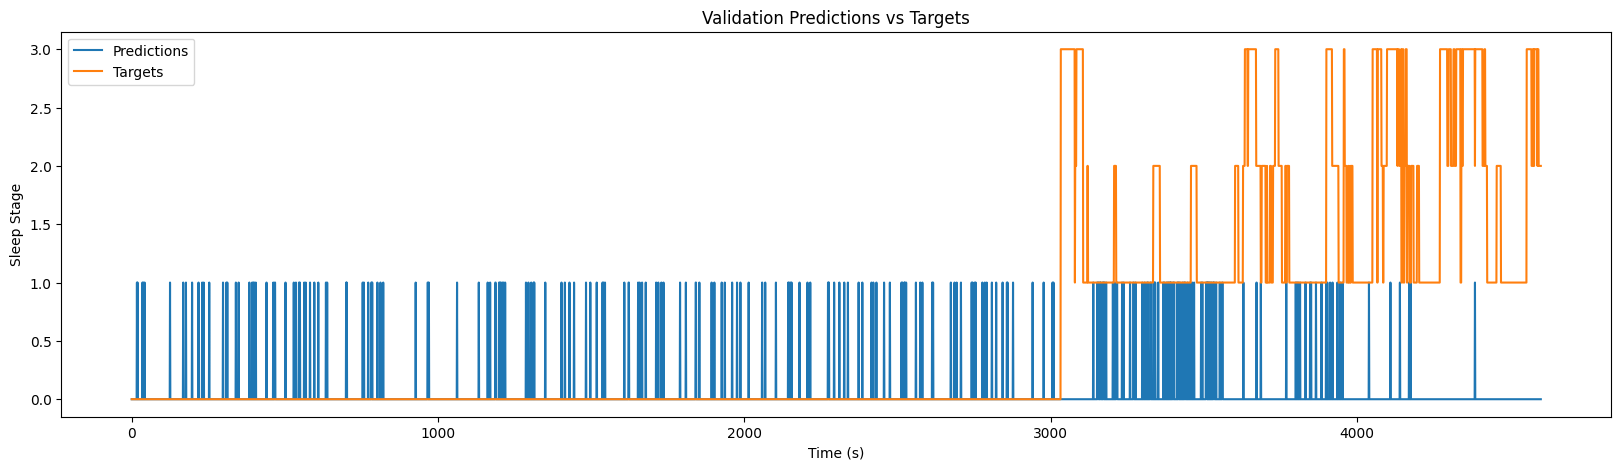

Processing file: n10.edf
New raw created successfully with EEG Ch only
filename: n10.txt
Shape of dataframe: (1111, 6)
Start time of annotations: 23:24:52
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=13194240
    Range : 0 ... 13194239 =      0.000 ... 25769.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=13194240
    Range : 0 ... 13194239 =      0.000 ... 25769.998 secs
Ready.
Features DataFrame created successfully with shape (25770, 30)
Balanced data has shape (5414, 30) (5414,)
Processing file: n11.edf
New raw created successfully with EEG Ch only
filename: n11.txt
Shape of dataframe: (1416, 6)
Start time of annotations: 22:37:16
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=16158720
    Range : 0 ... 16158719 =      0.000 ... 31559.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=16158720
    Range : 0 ... 16158719 =  

(21769, 30, 1)

(21769,)

(3120, 30, 1)

(3120,)

Counts by label: {0: 11617, 3: 2743, 2: 1547, 1: 5862}
Naive Accuracy: 53.36%


((#21769) [0,1,2,3,4,5,6,7,8,9...],
 (#3120) [21769,21770,21771,21772,21773,21774,21775,21776,21777,21778...])

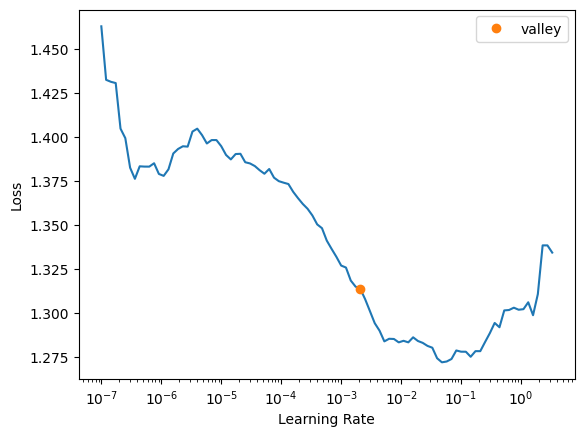

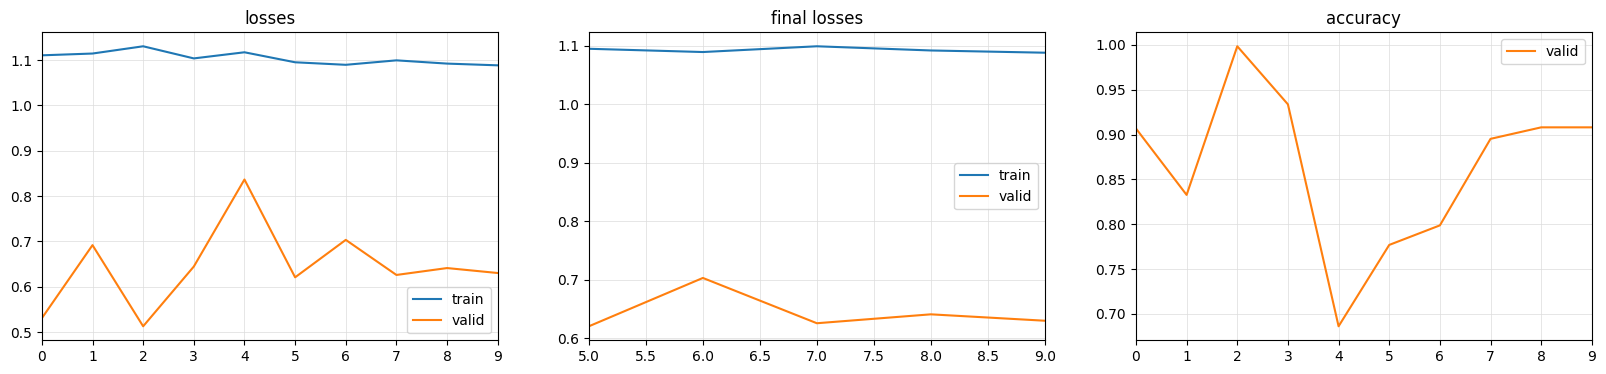

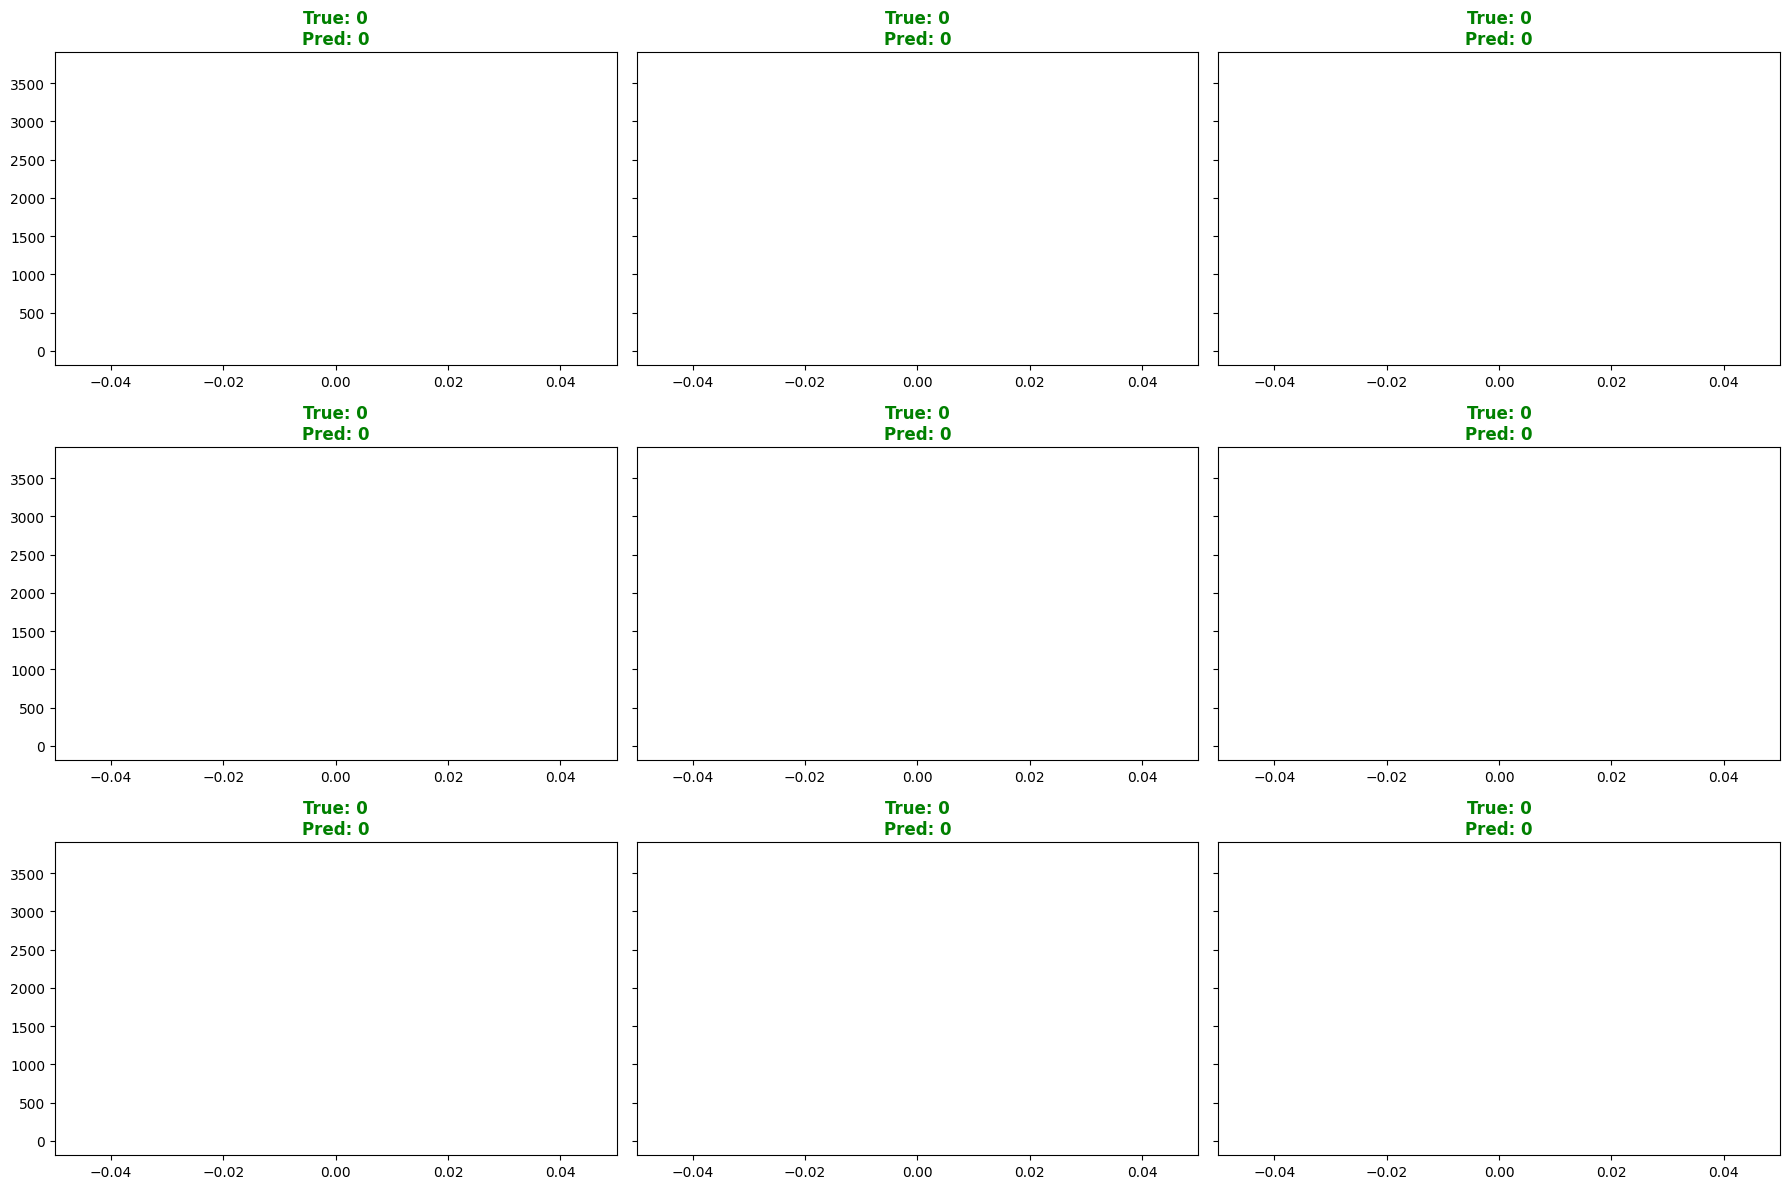

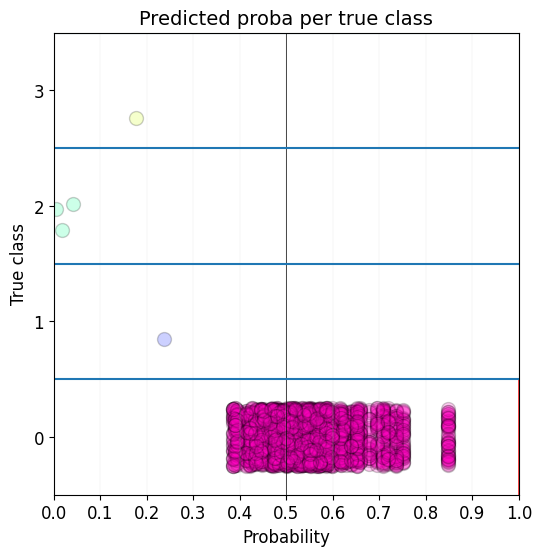

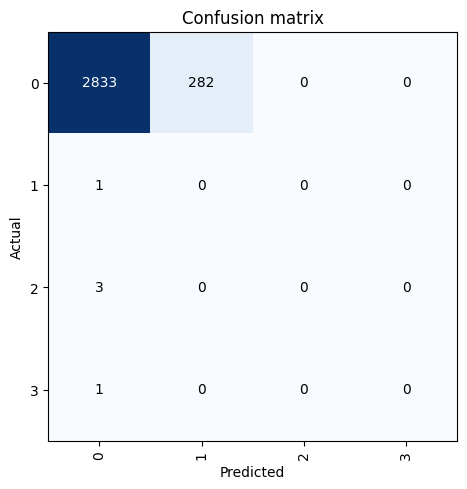

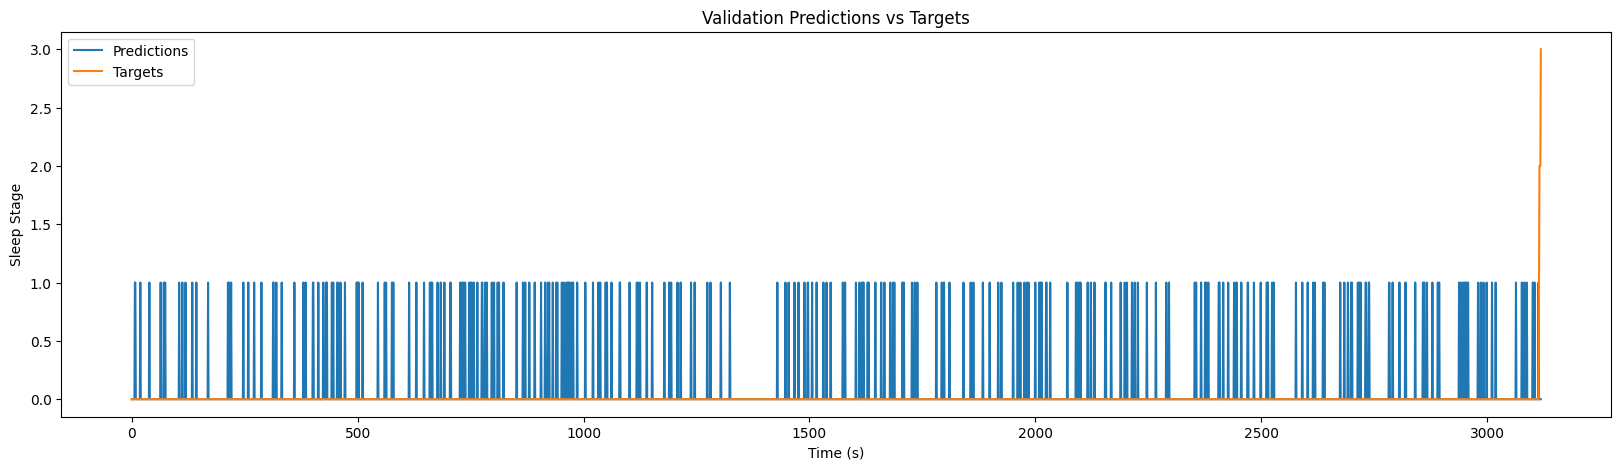

Processing file: n10.edf
New raw created successfully with EEG Ch only
filename: n10.txt
Shape of dataframe: (1111, 6)
Start time of annotations: 23:24:52
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=13194240
    Range : 0 ... 13194239 =      0.000 ... 25769.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=13194240
    Range : 0 ... 13194239 =      0.000 ... 25769.998 secs
Ready.
Features DataFrame created successfully with shape (25770, 30)
Balanced data has shape (5414, 30) (5414,)
Processing file: n11.edf
New raw created successfully with EEG Ch only
filename: n11.txt
Shape of dataframe: (1416, 6)
Start time of annotations: 22:37:16
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=16158720
    Range : 0 ... 16158719 =      0.000 ... 31559.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=16158720
    Range : 0 ... 16158719 =  

(20617, 30, 1)

(20617,)

(4272, 30, 1)

(4272,)

Counts by label: {0: 12596, 3: 1823, 2: 949, 1: 5249}
Naive Accuracy: 61.10%


((#20617) [0,1,2,3,4,5,6,7,8,9...],
 (#4272) [20617,20618,20619,20620,20621,20622,20623,20624,20625,20626...])

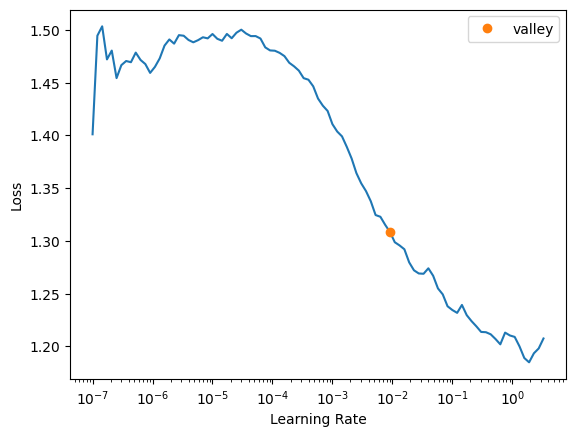

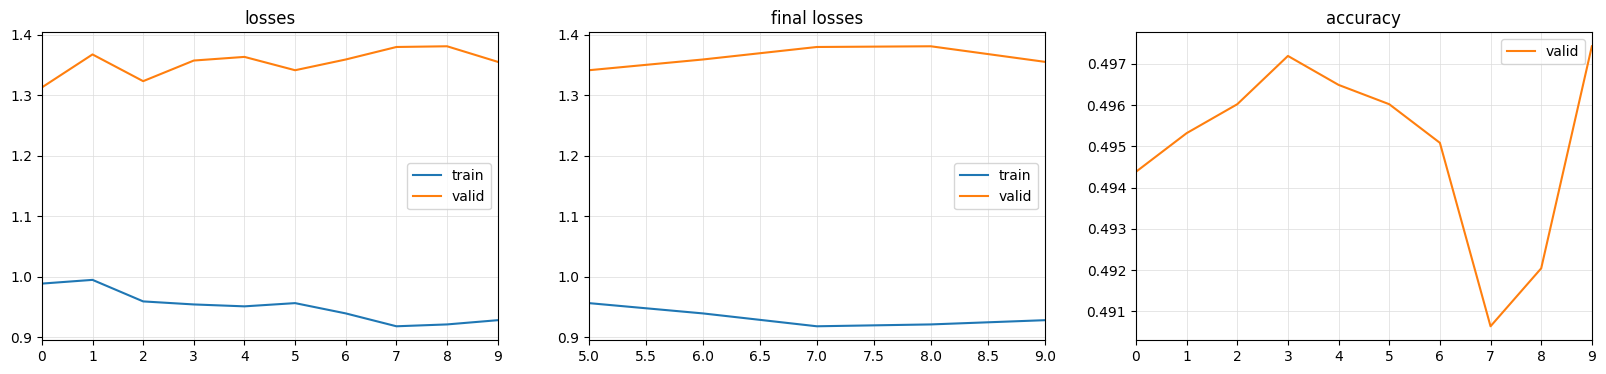

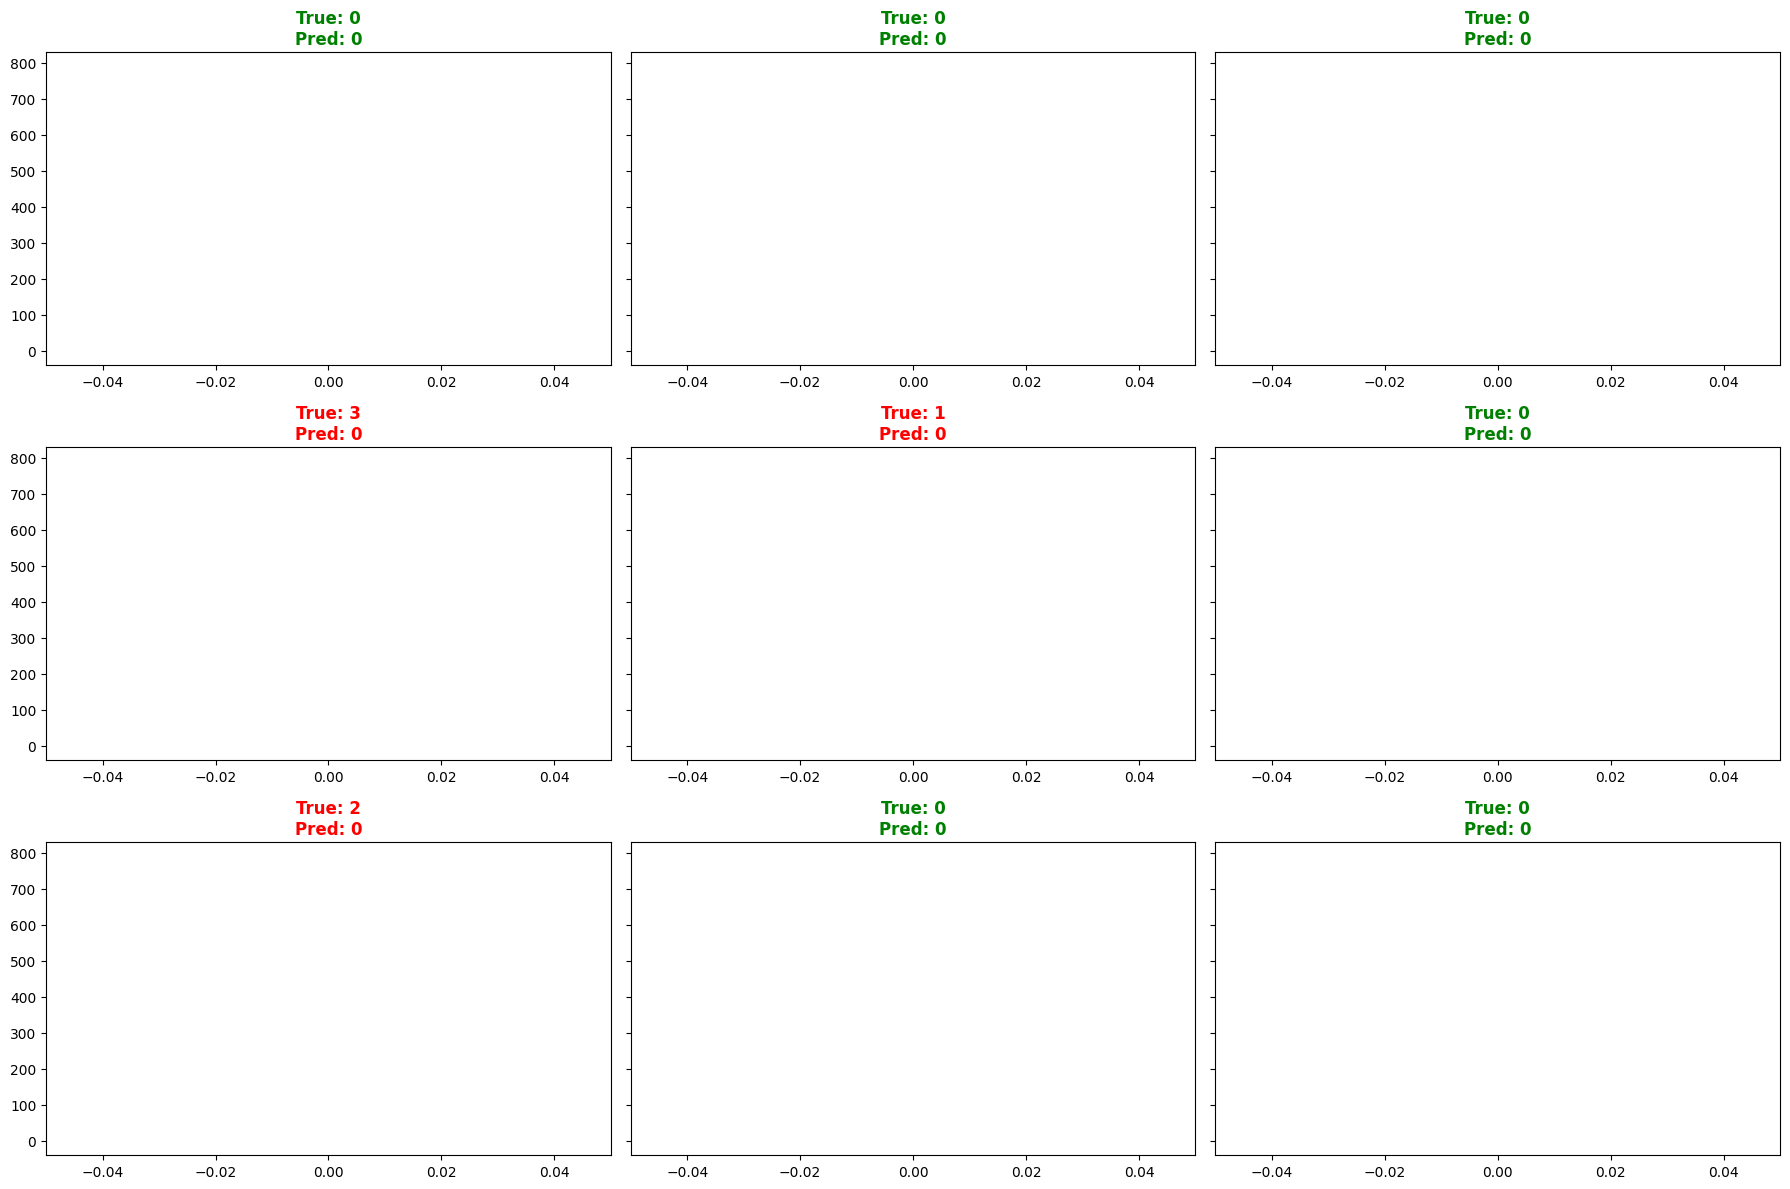

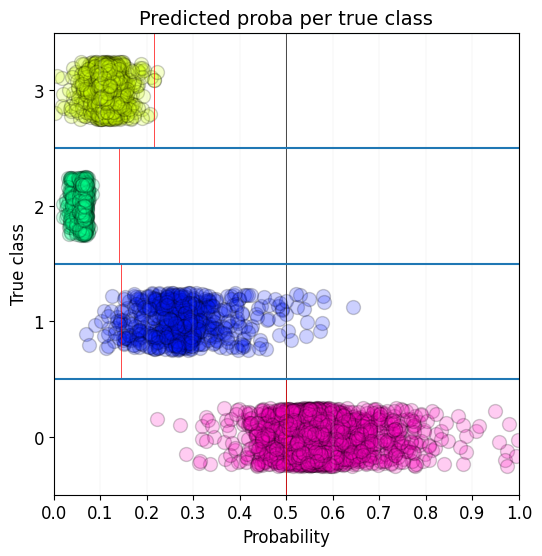

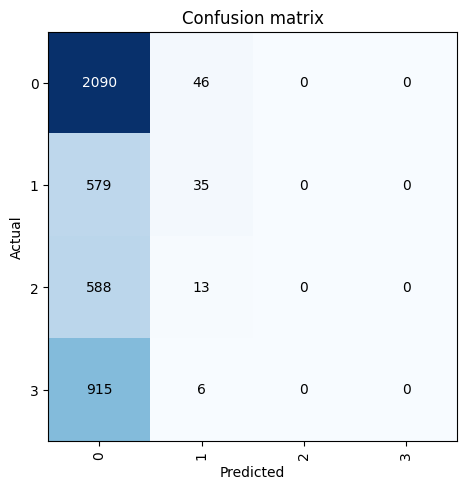

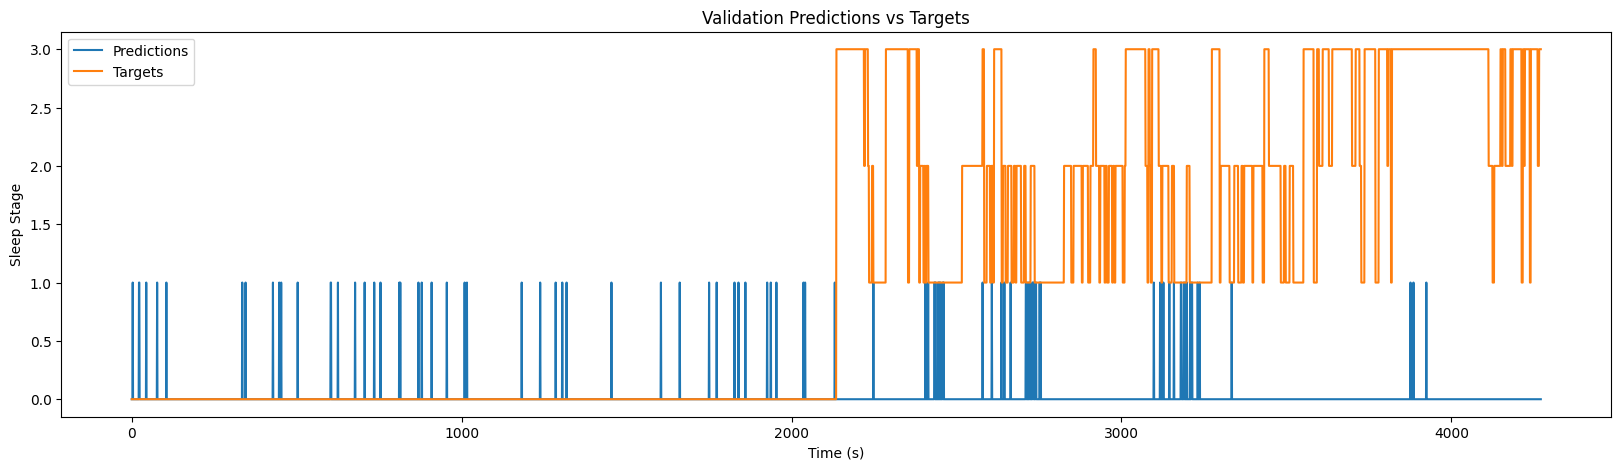

Processing file: n10.edf
New raw created successfully with EEG Ch only
filename: n10.txt
Shape of dataframe: (1111, 6)
Start time of annotations: 23:24:52
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=13194240
    Range : 0 ... 13194239 =      0.000 ... 25769.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=13194240
    Range : 0 ... 13194239 =      0.000 ... 25769.998 secs
Ready.
Features DataFrame created successfully with shape (25770, 30)
Balanced data has shape (5414, 30) (5414,)
Processing file: n11.edf
New raw created successfully with EEG Ch only
filename: n11.txt
Shape of dataframe: (1416, 6)
Start time of annotations: 22:37:16
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=16158720
    Range : 0 ... 16158719 =      0.000 ... 31559.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=16158720
    Range : 0 ... 16158719 =  

(17407, 30, 1)

(17407,)

(7482, 30, 1)

(7482,)

Counts by label: {0: 10991, 3: 2170, 2: 1222, 1: 3024}
Naive Accuracy: 63.14%


((#17407) [0,1,2,3,4,5,6,7,8,9...],
 (#7482) [17407,17408,17409,17410,17411,17412,17413,17414,17415,17416...])

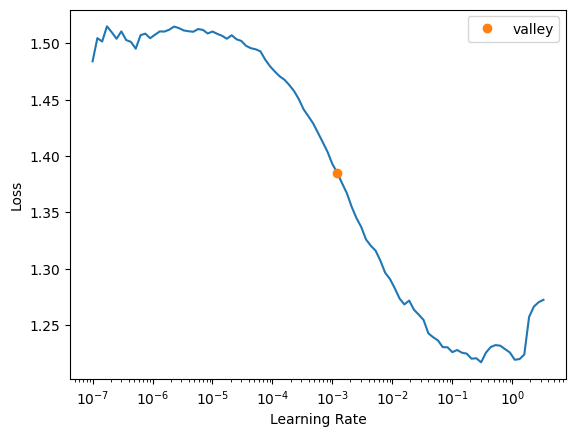

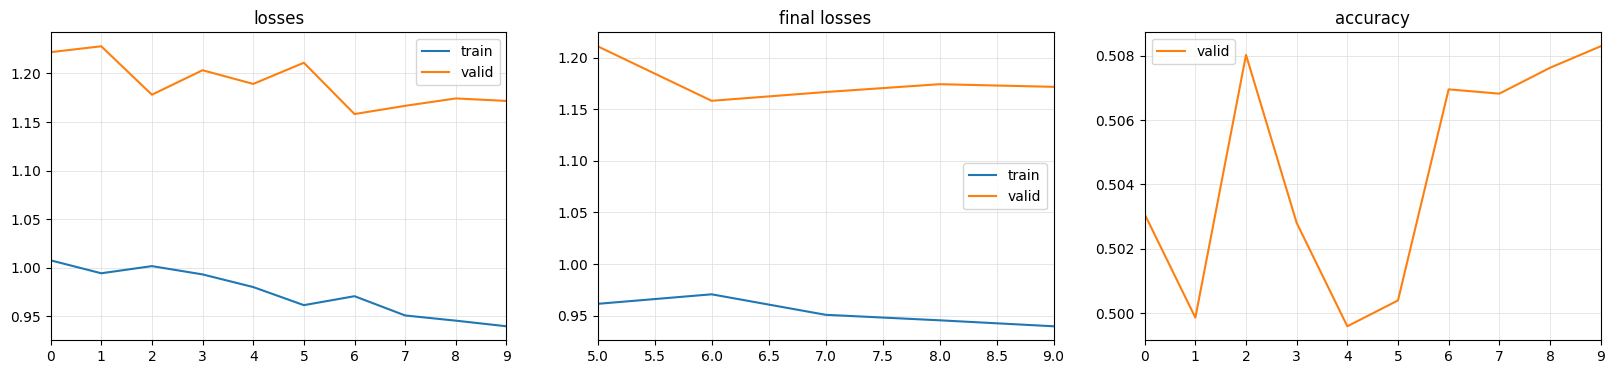

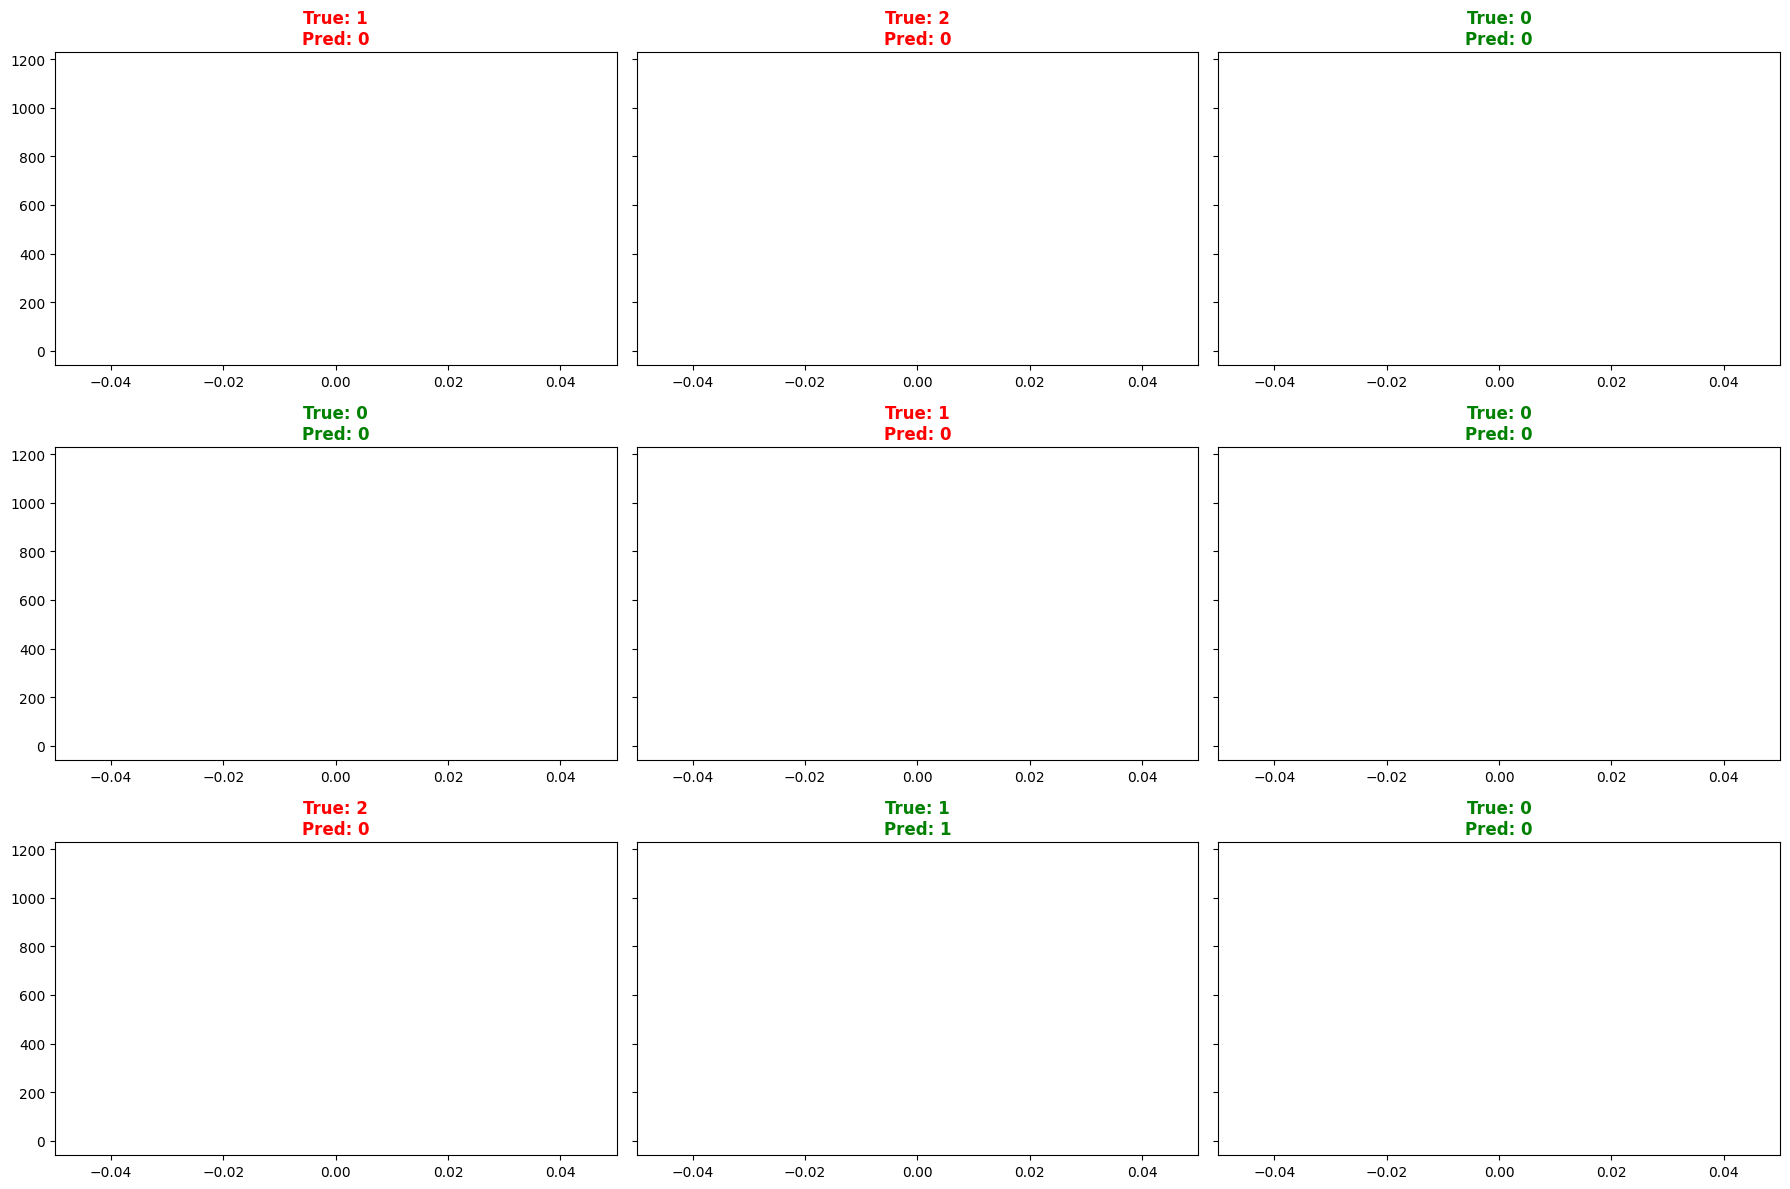

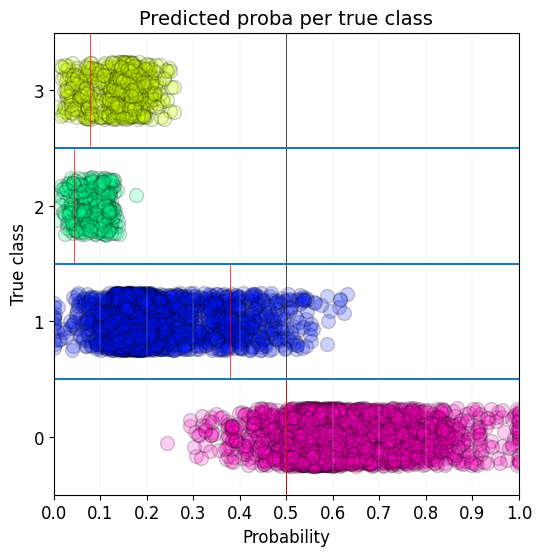

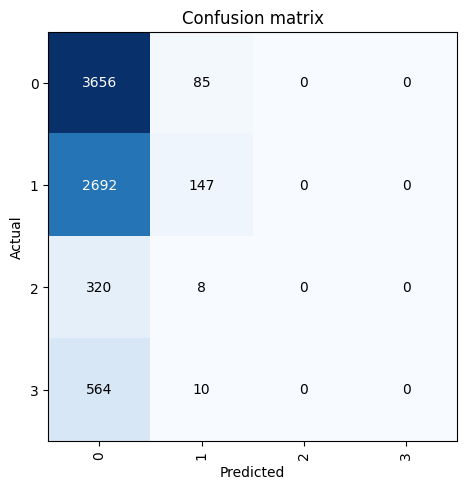

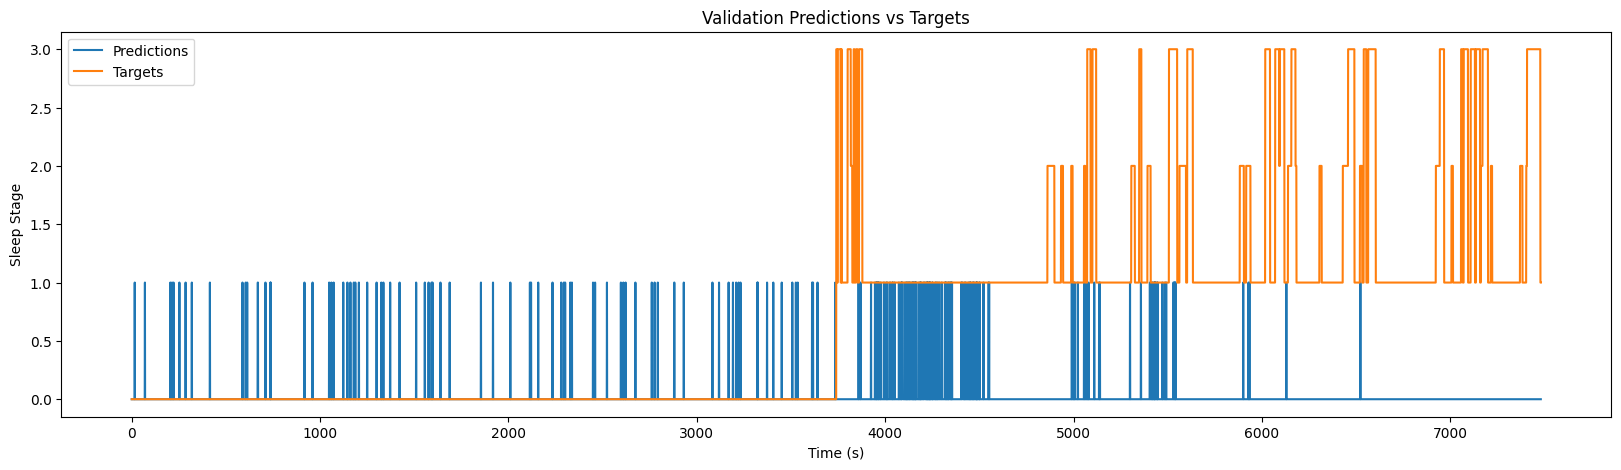

In [ ]:
# train the model on these edf files: n1, n2, n3, n5, n10, n11
train_files = ['n2.edf', 'n3.edf', 'n5.edf', 'n10.edf', 'n11.edf']

# Filter the edf_files list if it has the name in the train_files list
filtered_edf_files = [file for file in edf_files if any(train_file in file for train_file in train_files)]

get_train_valid_splits(filtered_edf_files)


In [ ]:
(24050, 30, 1)
(24050,)

(5414, 30, 1)
(5414,)

In [ ]:
# find edf_files which have EEG_data.info["sfreq"] = 512 Hz
five_one_two = [file for file in edf_files if mne.io.read_raw_edf(dataset_path + "\\" + file).info["sfreq"] == 512]


In [ ]:
# check if five one two files have 5 channels 
for file in five_one_two:
    edf_data = mne.io.read_raw_edf(dataset_path + "\\" + file)
    if len(edf_data.ch_names) == 5:
        print(f"{file} has 5 channels------------------------------")

In [ ]:
['n1.edf',
 'n10.edf',
 'n11.edf',
 'n2.edf',
 'n3.edf',
 'n5.edf',
 'nfle1.edf',
 'nfle12.edf',
 'nfle13.edf',
 'nfle14.edf',
 'nfle15.edf',
 'nfle16.edf',
 'nfle17.edf',
 'nfle18.edf',
 'nfle2.edf',
 'nfle21.edf',
 'nfle22.edf',
 'nfle24.edf',
 'nfle27.edf',
 'nfle28.edf',
 'nfle29.edf',
 'nfle3.edf',
 'nfle30.edf',
 'nfle32.edf',
 'nfle33.edf',
 'nfle34.edf',
 'nfle35.edf',
 'nfle36.edf',
 'nfle37.edf',
 'nfle38.edf',
 'nfle39.edf',
 'nfle4.edf',
 'nfle40.edf',
 'nfle5.edf',
 'nfle7.edf',
 'nfle9.edf',]